### Possible Areas to Examine

+ *How does time of day affect an order?*
- *What types of items are reordered most often?*
- How many different cart sizes do there appear to be among buyers, and what meaningful differences exist in those baskets of goods?
- How does order affect when a user adds something to their cart?
- Note: This data set is quite large, and taking a random 10-percent sample (with justification) is acceptable.

- Build model that predicts size of cart based on products chosen?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from functools import partial
from sklearn import metrics
import pandas as pd
import math
from IPython.display import Markdown, display
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
departments = pd.read_csv('departments.csv')
aisles = pd.read_csv('aisles.csv')

### Creating One Large DataFrame With All DataFrames Merged

In [3]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [4]:
order_products_train.shape

(1384617, 4)

In [5]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
order_products_prior.shape

(32434489, 4)

In [7]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [10]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [11]:
df = pd.merge(products, departments, on='department_id')

In [12]:
df2 = pd.merge(products, departments, on='department_id')

In [13]:
df = pd.merge(df, order_products_prior, on='product_id')

In [14]:
df2 = pd.merge(df2, order_products_train, on='product_id')

In [15]:
df = pd.merge(df, aisles, on='aisle_id')

In [16]:
df2 = pd.merge(df2, aisles, on='aisle_id')

In [17]:
df2 = pd.merge(df2, orders, on='order_id')
test_data = df2

In [18]:
df = pd.merge(df, orders, on='order_id')
train_data = df

In [19]:
train_data.isnull().sum(axis=0)

product_id                      0
product_name                    0
aisle_id                        0
department_id                   0
department                      0
order_id                        0
add_to_cart_order               0
reordered                       0
aisle                           0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
dtype: int64

In [20]:
train_data['days_since_prior_order'].max()

30.0

**Days since prior order has a lot of nans. This may be because there are no days since prior order, so we will convert those to 31**

In [21]:
train_data['days_since_prior_order'].fillna(31, inplace=True)

In [22]:
train_data.isnull().sum(axis=0)

product_id                0
product_name              0
aisle_id                  0
department_id             0
department                0
order_id                  0
add_to_cart_order         0
reordered                 0
aisle                     0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

In [23]:
test_data.isnull().sum(axis=0)

product_id                0
product_name              0
aisle_id                  0
department_id             0
department                0
order_id                  0
add_to_cart_order         0
reordered                 0
aisle                     0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

In [24]:
test_data['days_since_prior_order'].max()

30.0

In [25]:
test_data['days_since_prior_order'].fillna(31, inplace=True)

In [26]:
test_data.isnull().sum(axis=0)

product_id                0
product_name              0
aisle_id                  0
department_id             0
department                0
order_id                  0
add_to_cart_order         0
reordered                 0
aisle                     0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

### Analyzing Orders DataFrame

**How many unique orders and unique products are there?**

In [27]:
unique_orders = len(train_data['order_id'].unique())
unique_products = len(train_data['product_id'].unique())
print(f"Number of Unique Orders: {unique_orders}")
print(f"Number of Unique Products: {unique_products}")

Number of Unique Orders: 3214874
Number of Unique Products: 49677


In [28]:
unique_orders = len(test_data['order_id'].unique())
unique_products = len(test_data['product_id'].unique())
print(f"Number of Unique Orders: {unique_orders}")
print(f"Number of Unique Products: {unique_products}")

Number of Unique Orders: 131209
Number of Unique Products: 39123


**Orders DataFrame has labels 'Test', 'Train', and 'Prior'. These will be used for the model**

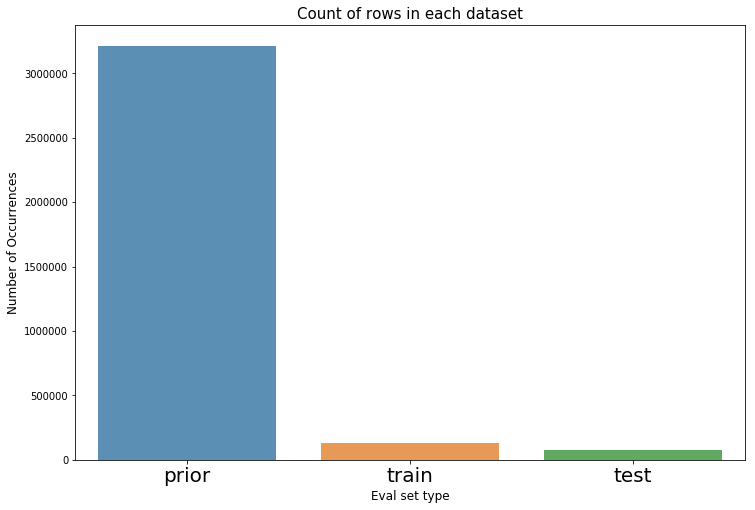

In [29]:
count_df = orders.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(count_df.index, count_df.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='horizontal', fontsize=20)
plt.show()

### This shows that we need to predict 75,000 orders

In [30]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

### Data page says we only have data for customer orders 4 to 100. We can check that by graphing the values. 

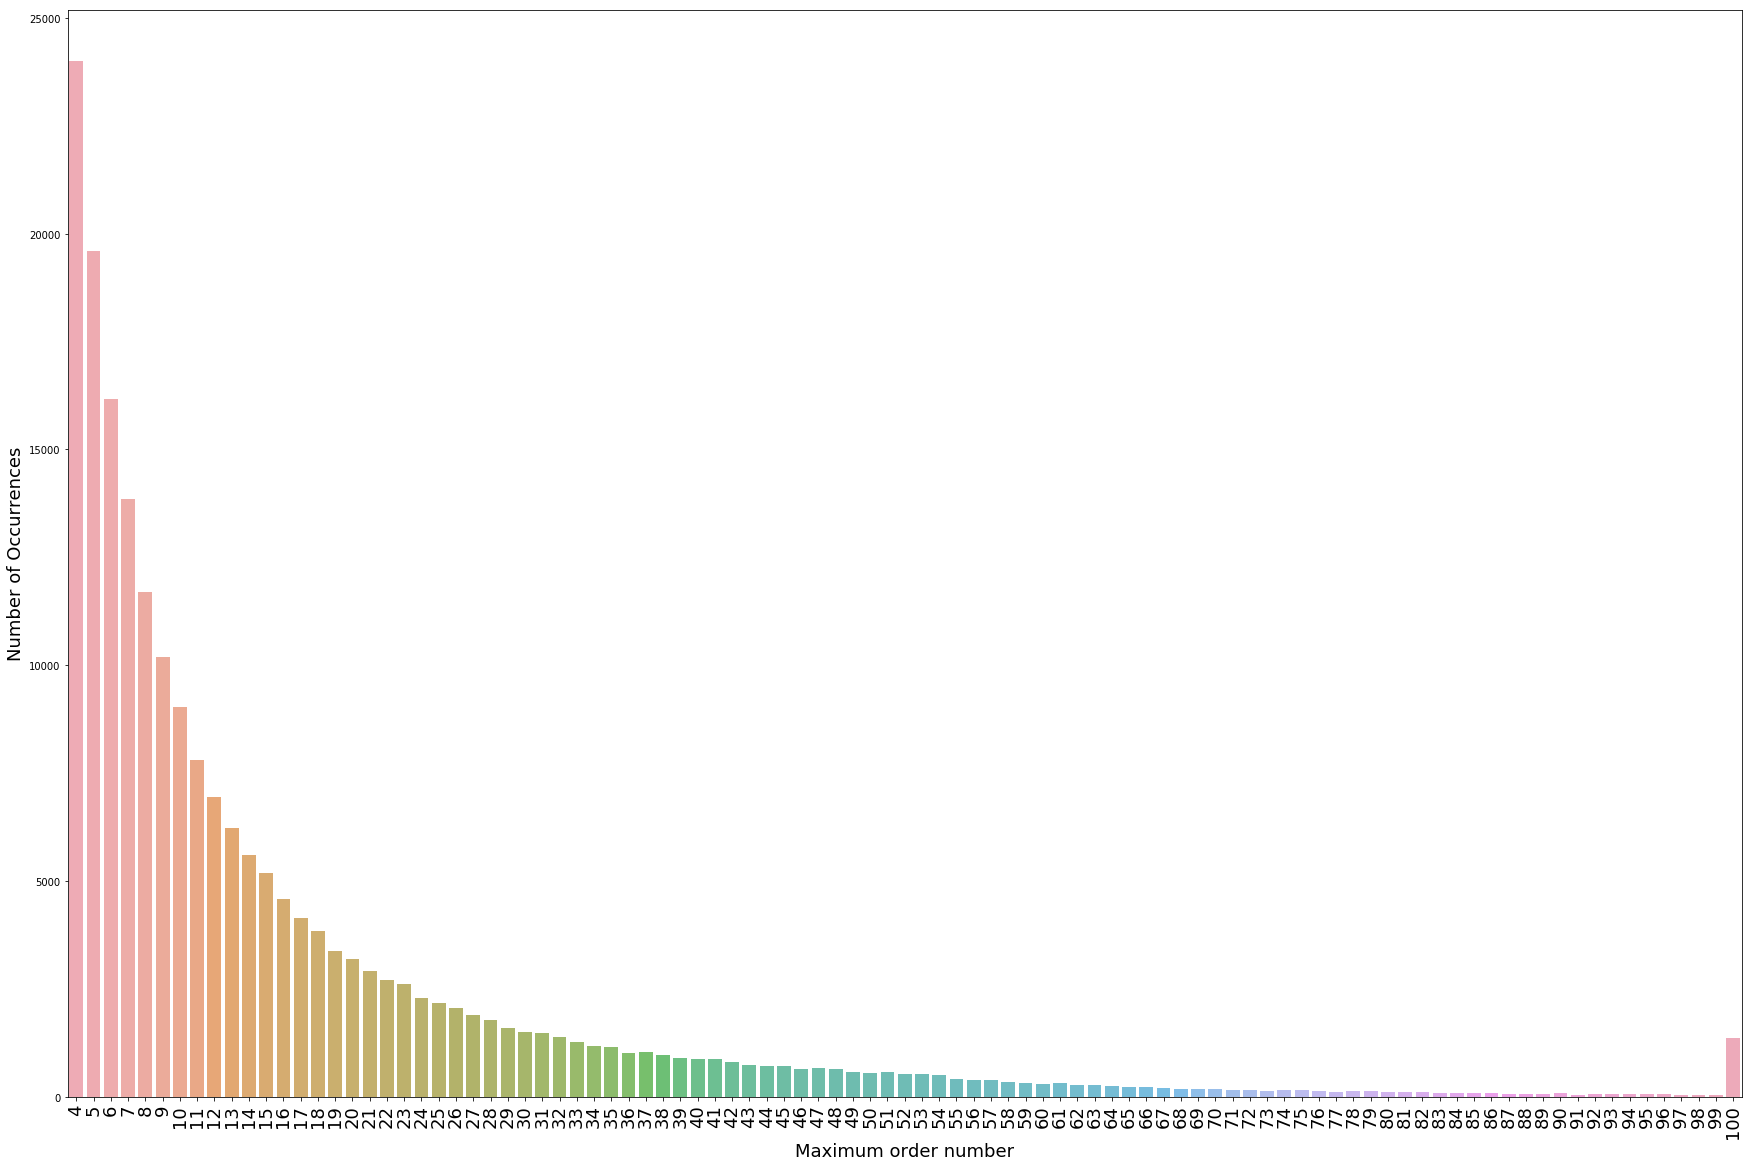

In [31]:
cnt_srs = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(30,20))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=18)
plt.xlabel('Maximum order number', fontsize=18)
plt.xticks(rotation='vertical', fontsize=18)
plt.show()

**We can also see that most customers ordered 4 orders**

### First Exploration: How does day of the week effect ordering?


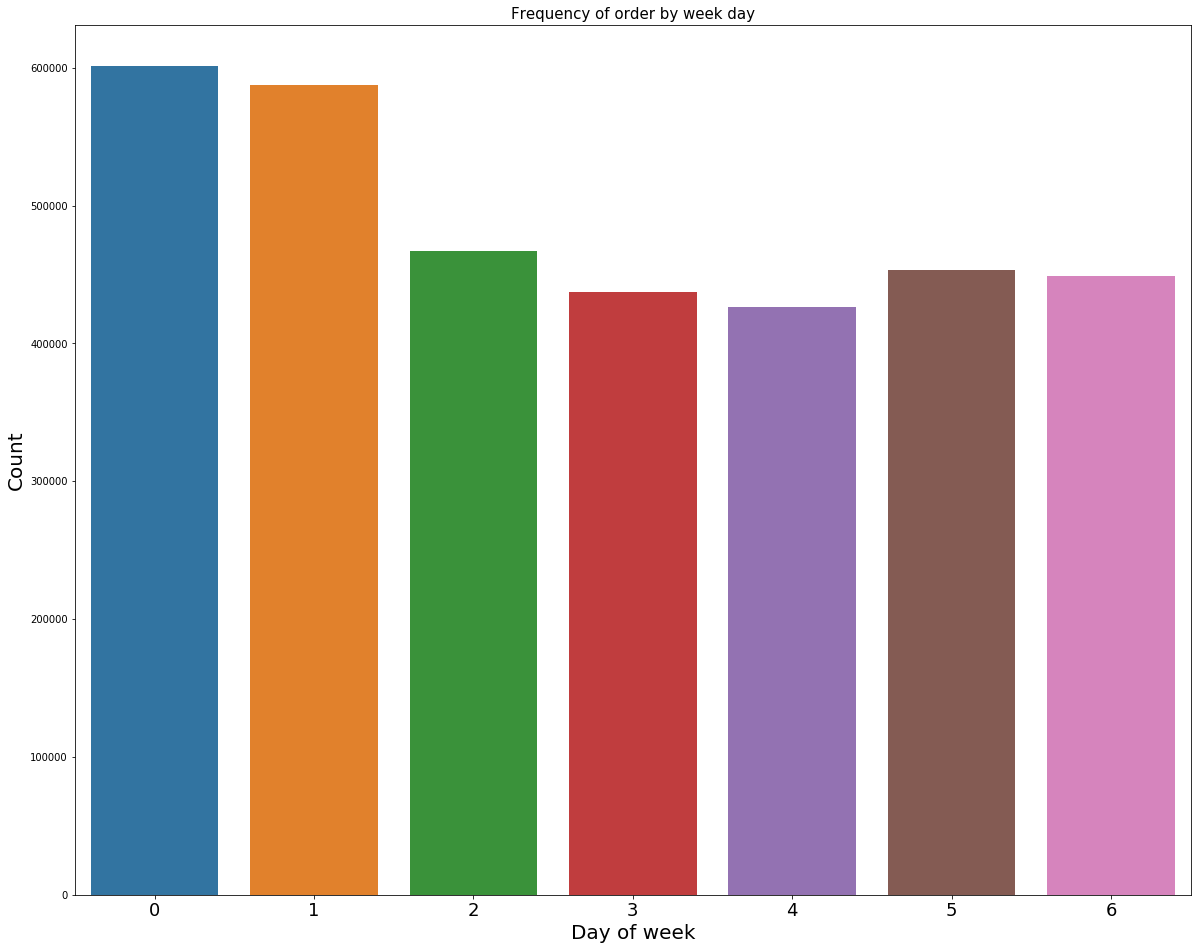

In [32]:
plt.figure(figsize=(20,16))
sns.countplot(x="order_dow", data=orders)
plt.ylabel('Count', fontsize=20)
plt.xlabel('Day of week', fontsize=20)
plt.xticks(rotation='horizontal', fontsize=18)
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

**According to the dictionary, 0 is Saturday. Therefore, Saturday and Sunday are the top shopping days, while Wednesday is the lowest.**

### Now we can see how the time of day effects ordering.


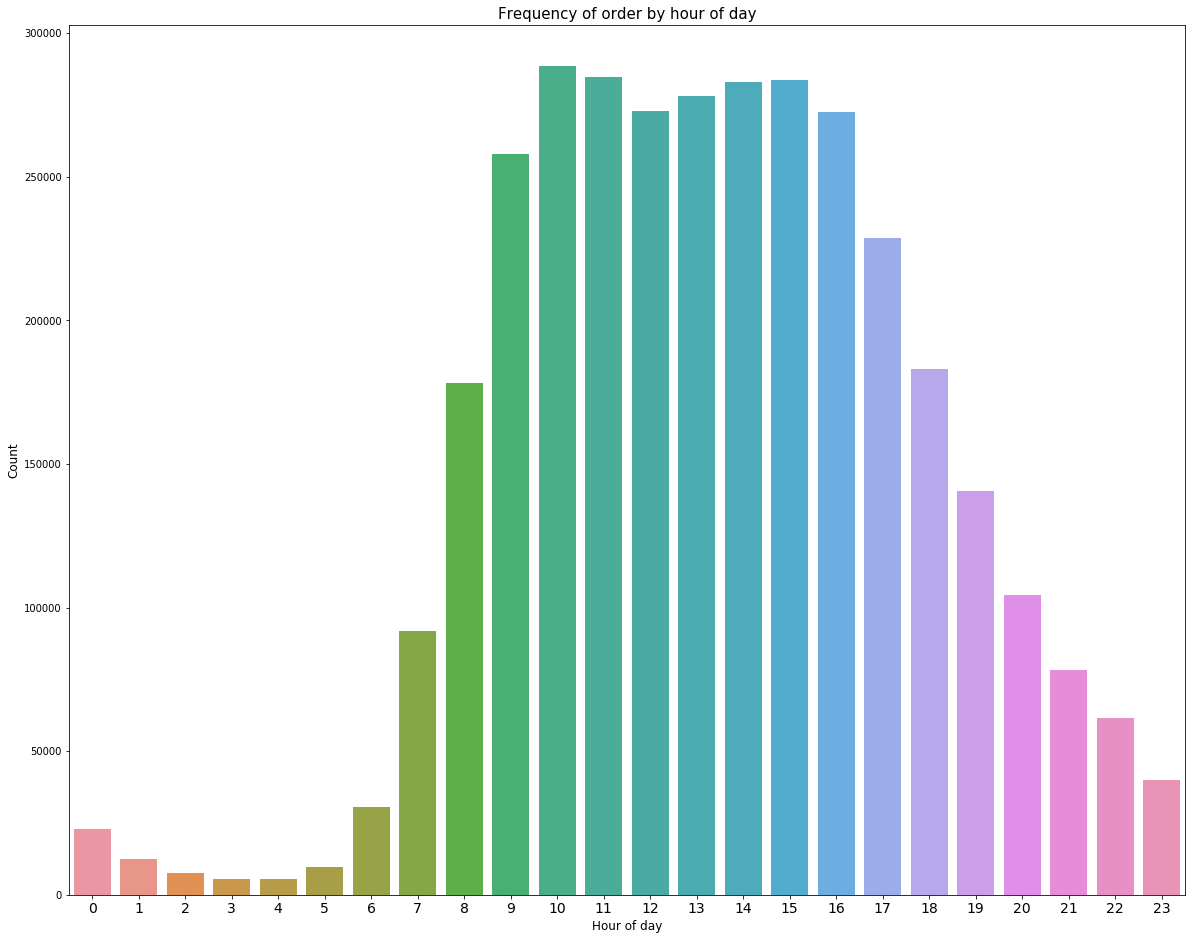

In [33]:
plt.figure(figsize=(20,16))
sns.countplot(x="order_hour_of_day", data=orders)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='horizontal', fontsize=14)
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

**Most shopping happens during the day, between the hours of 7am and 8pm.**

### We can combine the day of the week and the hour of the day to see that relationship

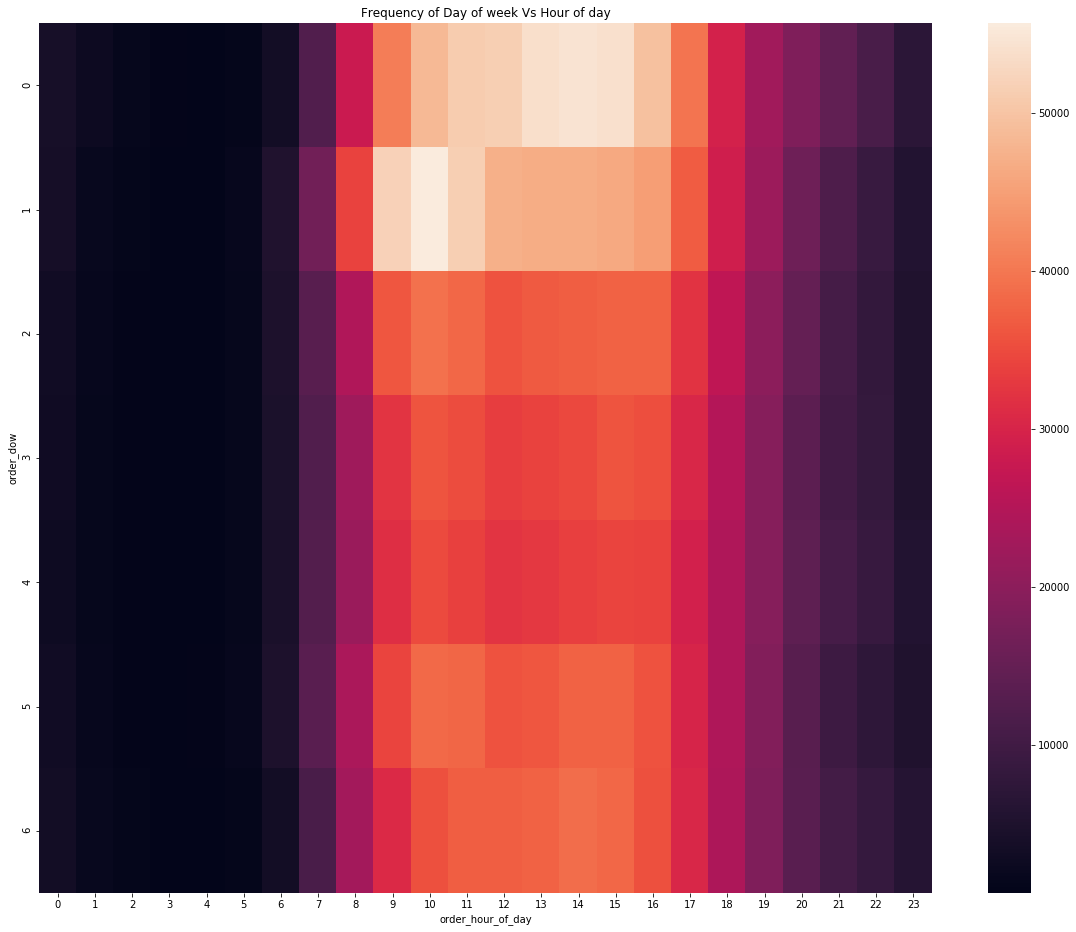

In [34]:
group_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
group_df = group_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(20,16))
sns.heatmap(group_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

**From this we can see that Saturday early afternoon and Sunday morning are the most frequent shopping times**

### To view the time interval between orders:

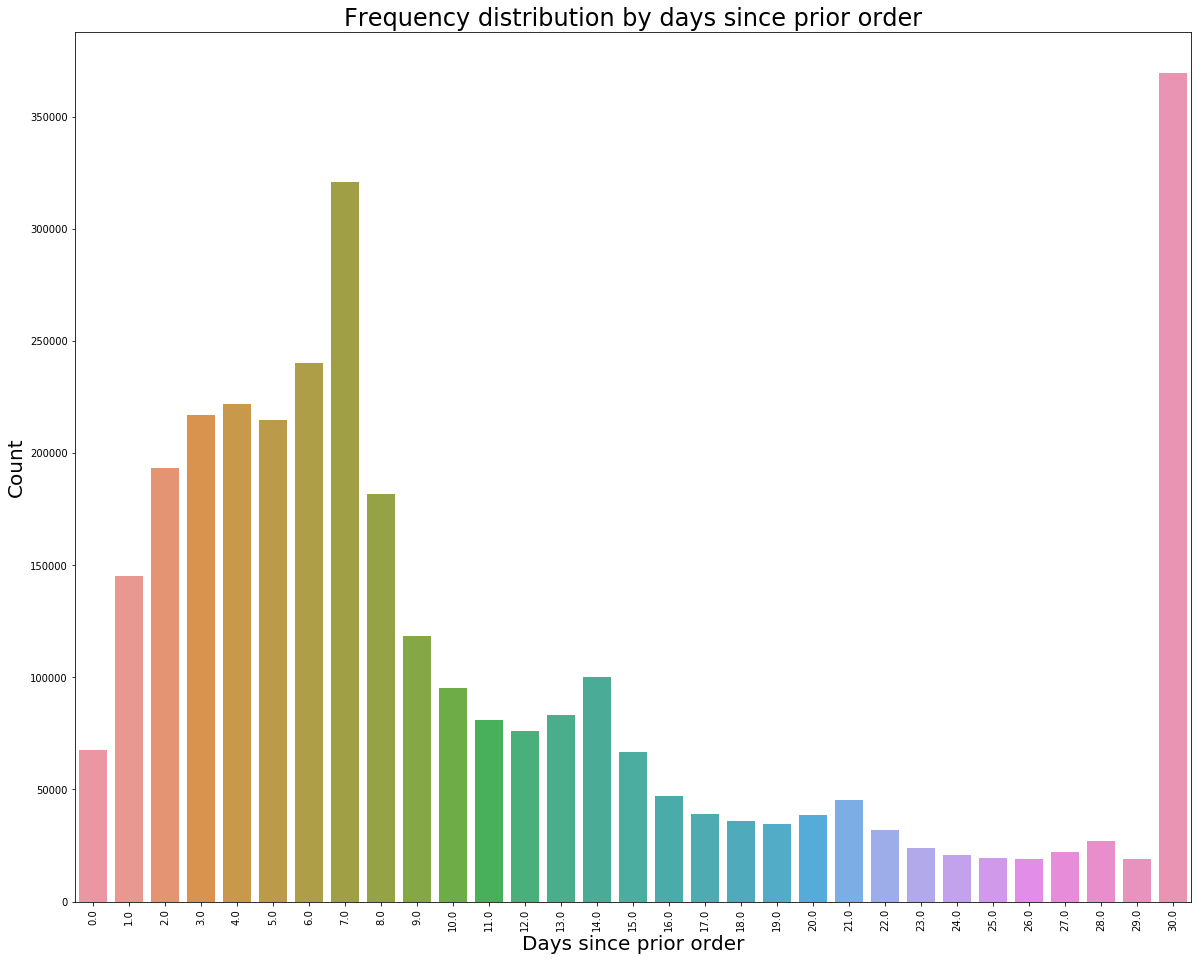

In [35]:
plt.figure(figsize=(20,16))
sns.countplot(x="days_since_prior_order", data=orders)
plt.ylabel('Count', fontsize=20)
plt.xlabel('Days since prior order', fontsize=20)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=24)
plt.show()

**Because there are peaks at 7 and 30, it shows most customers shop either once a week or once a month**

### What is the re-order percentage?

In [36]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


**The data says a reorder is a 1, so we can take the sum to determine how many reorders there were, divided by the number of orders total**

In [37]:
order_products_prior['reordered'].sum() / order_products_prior['reordered'].count()

0.5896974667922161

**For the train set, we can do the same thing**

In [38]:
order_products_train['reordered'].sum() / order_products_train['reordered'].count()

0.5985944127509629

**We can see that about 59% of products are reorders.**

### How many products did people usually order?

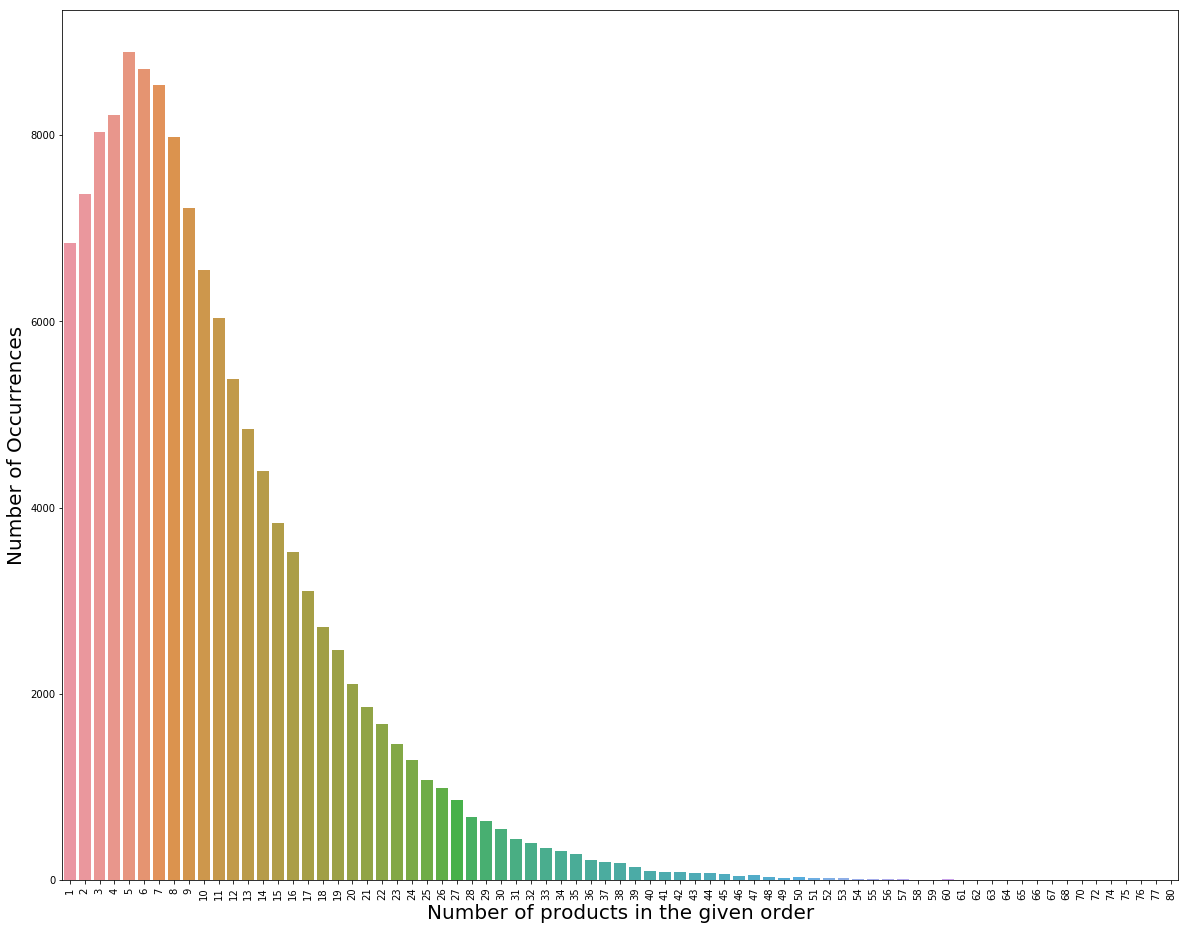

In [39]:
grouped = order_products_train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
counts = grouped['add_to_cart_order'].value_counts()

plt.figure(figsize=(20,16))
sns.barplot(counts.index, counts.values)
plt.ylabel('Number of Occurrences', fontsize=20)
plt.xlabel('Number of products in the given order', fontsize=20)
plt.xticks(rotation='vertical')
plt.show()

**We can see that there is a peak at 5, so most people bought 5 products per order.** 

**Now we can see what those types of products are by looking at the dataframe after combining a few dataframes together**

In [40]:
order_products_prior = pd.merge(order_products_prior, products, on='product_id', how='left')
order_products_prior = pd.merge(order_products_prior, aisles, on='aisle_id', how='left')
order_products_prior = pd.merge(order_products_prior, departments, on='department_id', how='left')
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [41]:
count_df = order_products_prior['product_name'].value_counts().reset_index().head(20)
count_df.columns = ['product_name', 'frequency_count']
count_df.head()

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584


**Four of the top five products are organic produce**

### Let's look at those items more closely

Text(0.5, 0, 'Product Name')

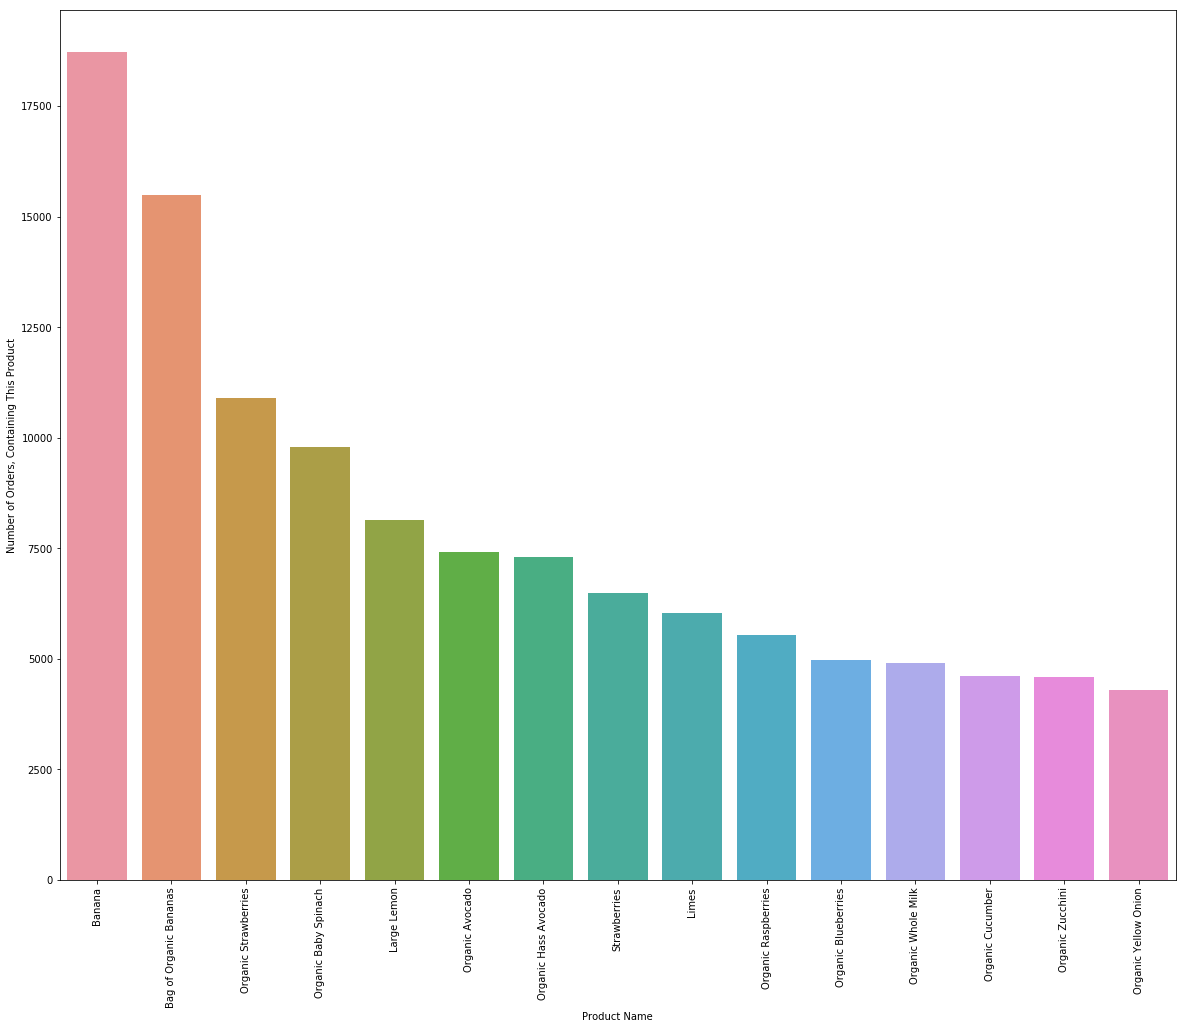

In [42]:
top_products = pd.merge(
    left=pd.DataFrame(test_data.groupby(['product_id'])['order_id']\
    .apply(lambda x: len(x.unique())).sort_values(ascending=False)[:15].reset_index('product_id')),
    right=pd.merge(left=pd.merge(left=products, right=departments, how='left'), right=aisles, how='left'),
    how='left')

f, ax = plt.subplots(figsize=(20, 16))
plt.xticks(rotation='vertical')
sns.barplot(top_products.product_name, top_products.order_id)
plt.ylabel('Number of Orders, Containing This Product')
plt.xlabel('Product Name')

**Bananas, both organic and not, were bought signicantly more than most other products**

### What products were most reordered?

**To determine this, we're going to take the probability of each item to be reordered.**

In [43]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0, sort=False)
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped[grouped.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:10]
grouped

C:\Users\Stephen Parvaresh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,product_id,reorder_sum,reorder_total,reorder_probability,product_name
2074,2075,84,90,0.933333,Serenity Ultimate Extrema Overnight Pads
27737,27740,94,102,0.921569,Chocolate Love Bar
35601,35604,93,104,0.894231,Maca Buttercups
38248,38251,99,111,0.891892,Benchbreak Chardonnay
36798,36801,88,99,0.888889,Organic Blueberry B Mega
10233,10236,114,131,0.870229,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.868421,Thousand Island Salad Snax
5455,5457,78,90,0.866667,Classic Carbonated Natural Mineral Water
35493,35496,394,457,0.862144,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.861436,Half And Half Ultra Pasteurized


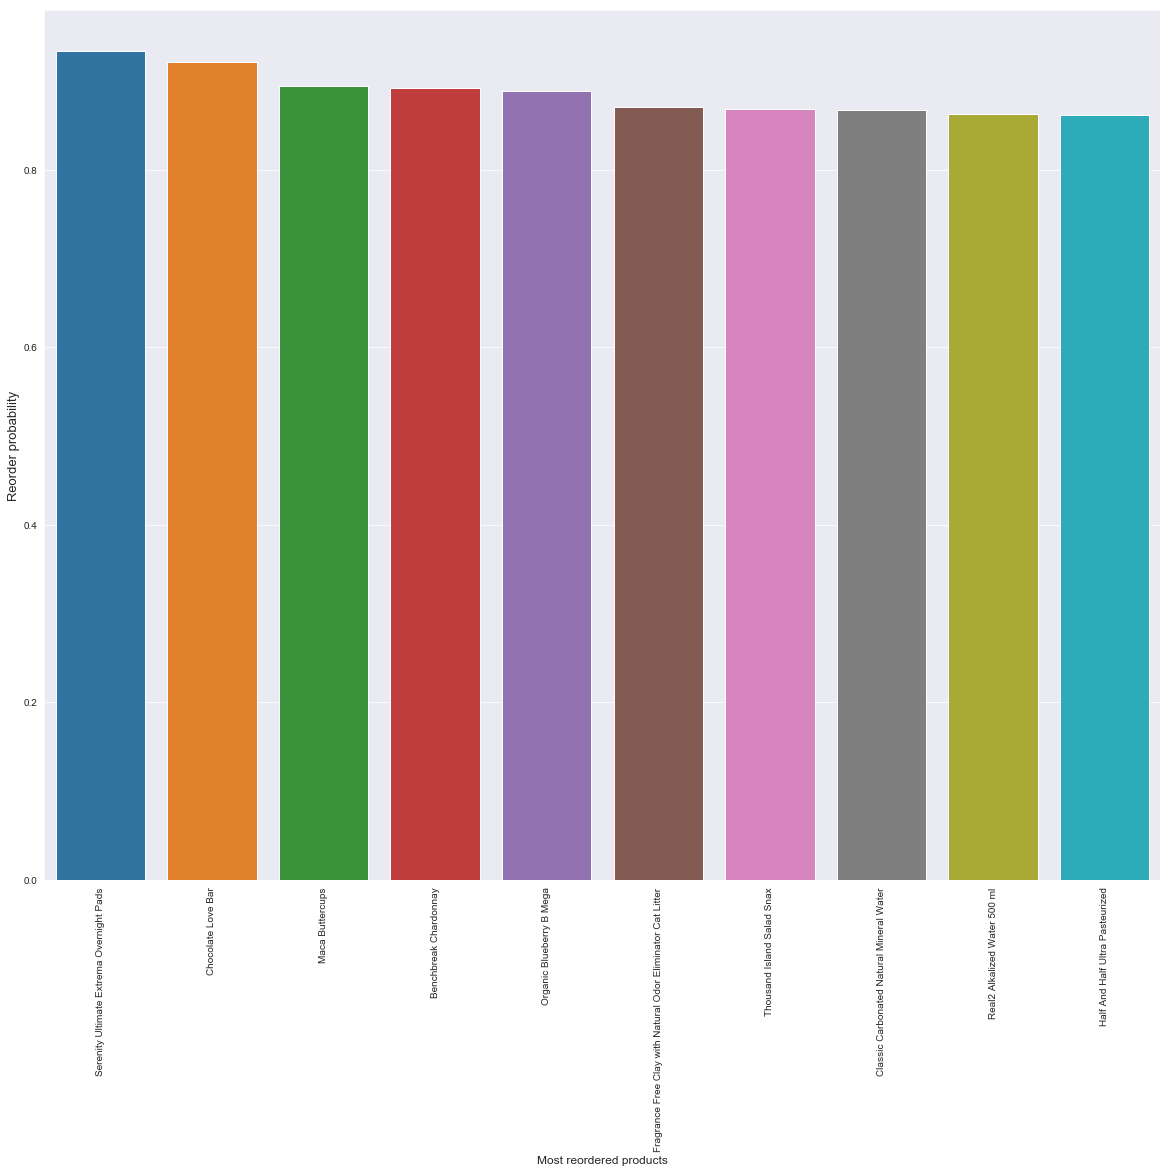

In [44]:
grouped  = grouped.groupby(['product_name']).sum()['reorder_probability'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(20, 16))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
# plt.ylim([0.85,0.95])
plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('Most reordered products', fontsize=12)
plt.show()

**Most reordered items were overnight pads, candy, and wine.**

### What is the distribution of departments?

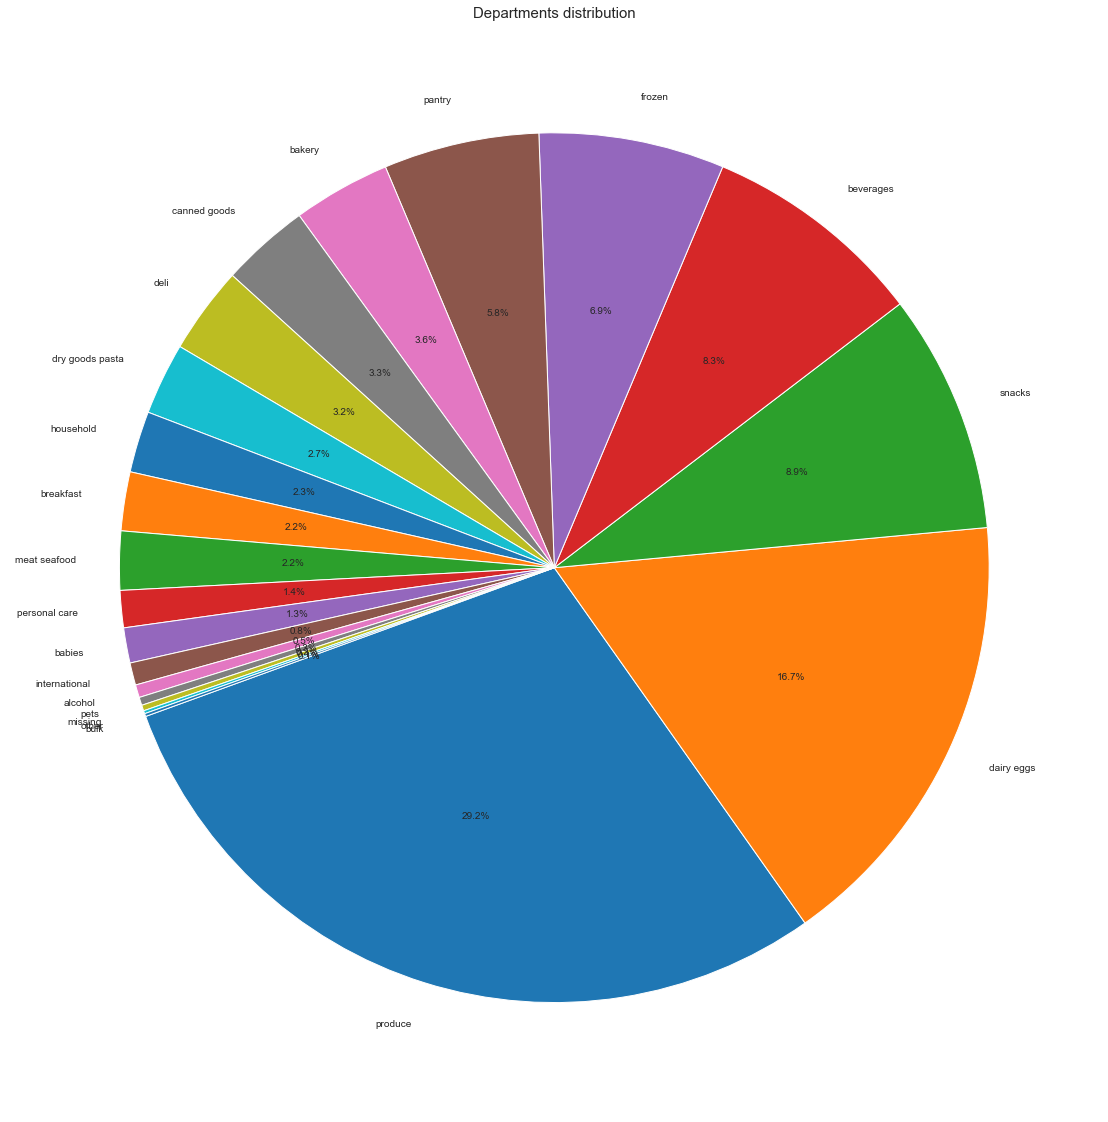

In [45]:
plt.figure(figsize=(20,20))
temp_series = train_data['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

**Produce is the largest aisle**

### What aisles are the most important?

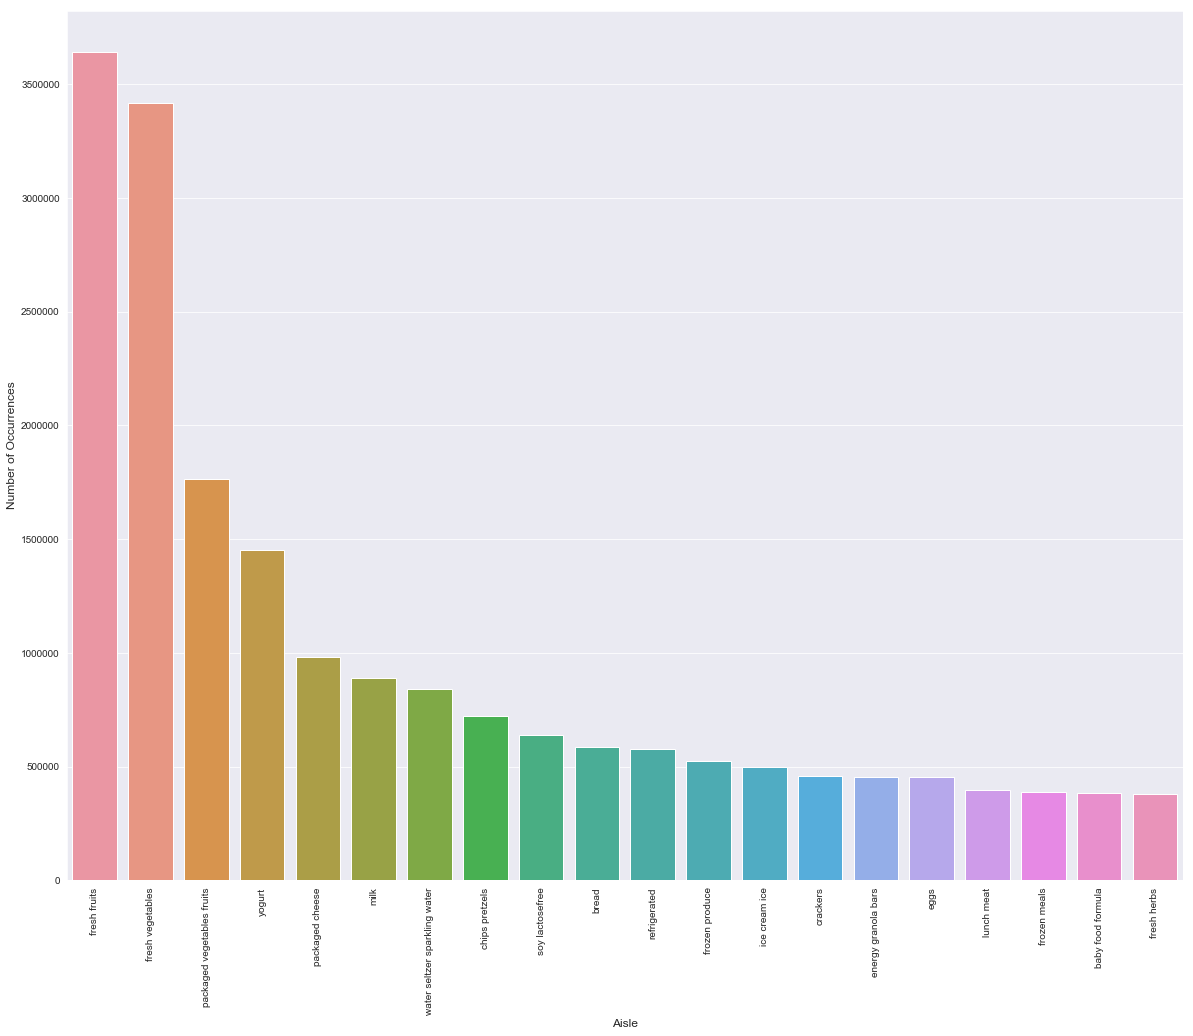

In [46]:
count_df = train_data['aisle'].value_counts().head(20)
plt.figure(figsize=(20,16))
sns.barplot(count_df.index, count_df.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

**Top two aisles are fresh fruits and fresh vegetables**

### Let's break down each department by aisle to find most important aisles. 

C:\Users\Stephen Parvaresh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


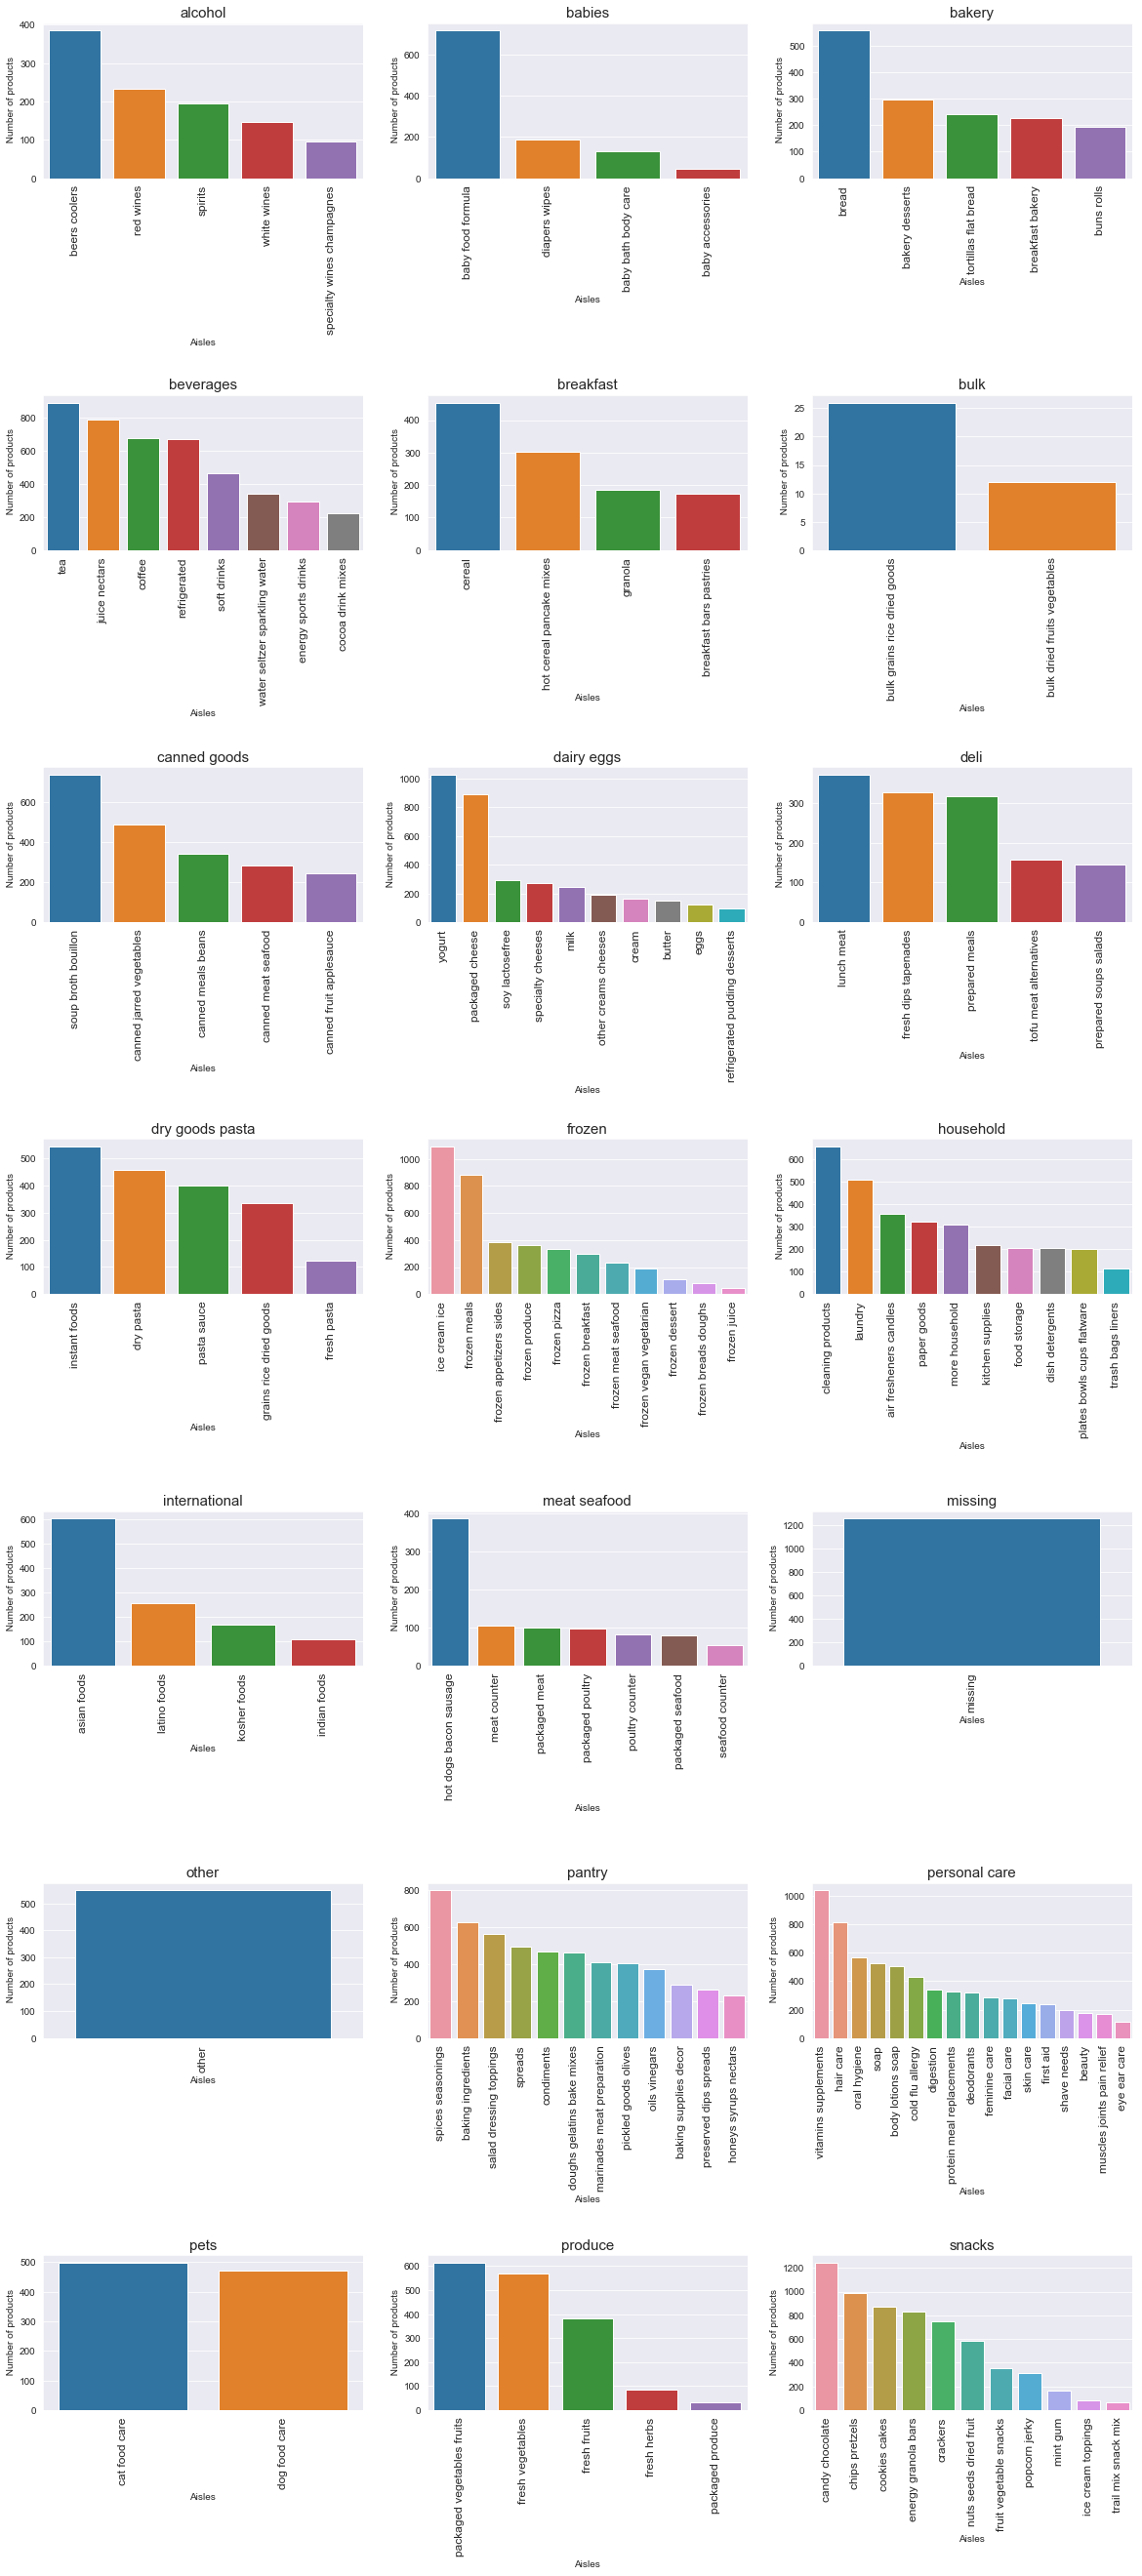

In [47]:
items  = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
grouped = items.groupby(["department", "aisle"])["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

### Now we can look at the relationship between how order of adding the product to the cart affects the reorder ratio.

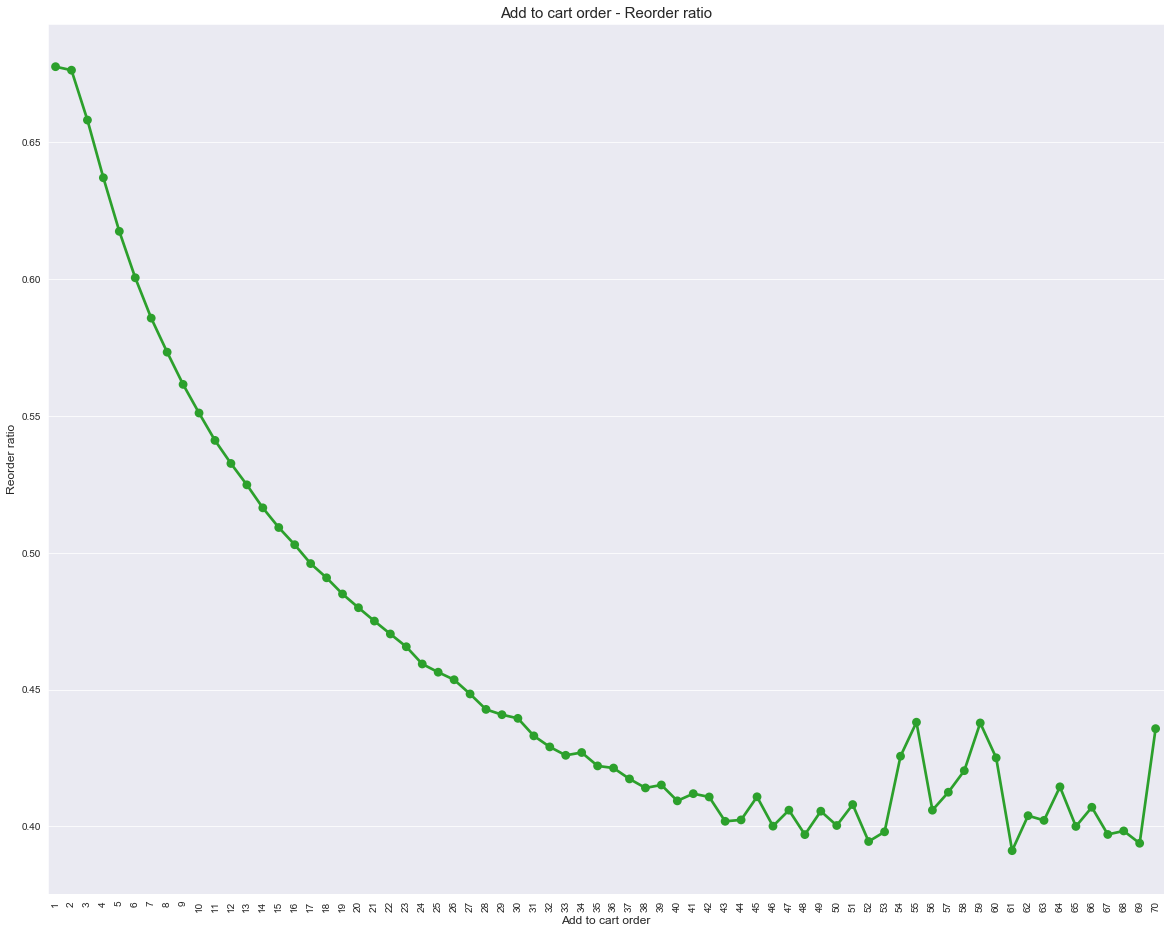

In [48]:
train_data["add_to_cart_order_mod"] = train_data["add_to_cart_order"].copy()
train_data["add_to_cart_order_mod"].loc[train_data["add_to_cart_order_mod"]>70] = 70
grouped_df = train_data.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(20,16))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

**Looks like the products that are added to the cart initially are more likely to be reordered again compared to the ones added later.**

### Reorder ratio by time-based variables

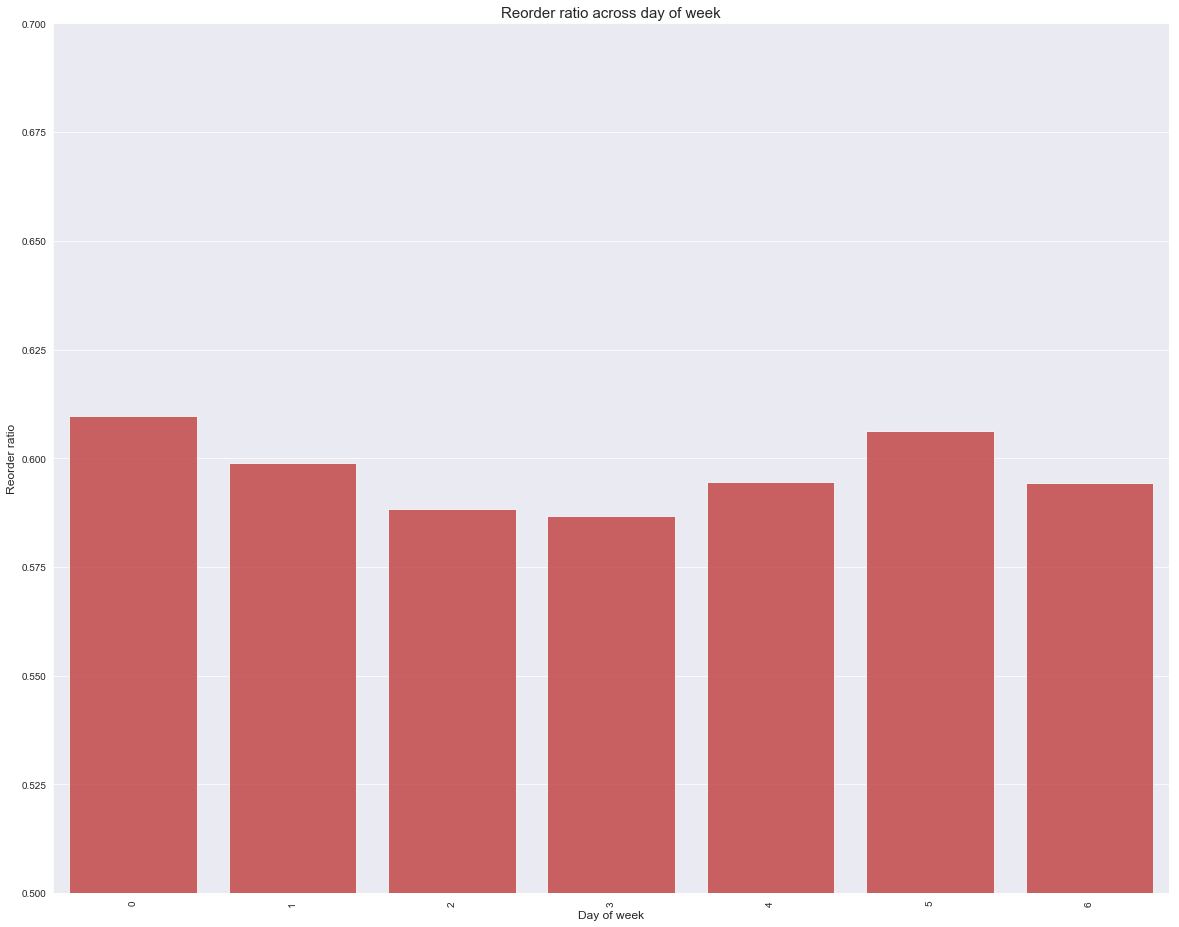

In [49]:
order_products_train = pd.merge(order_products_train, orders, on='order_id', how='left')
grouped_df = order_products_train.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(20,16))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

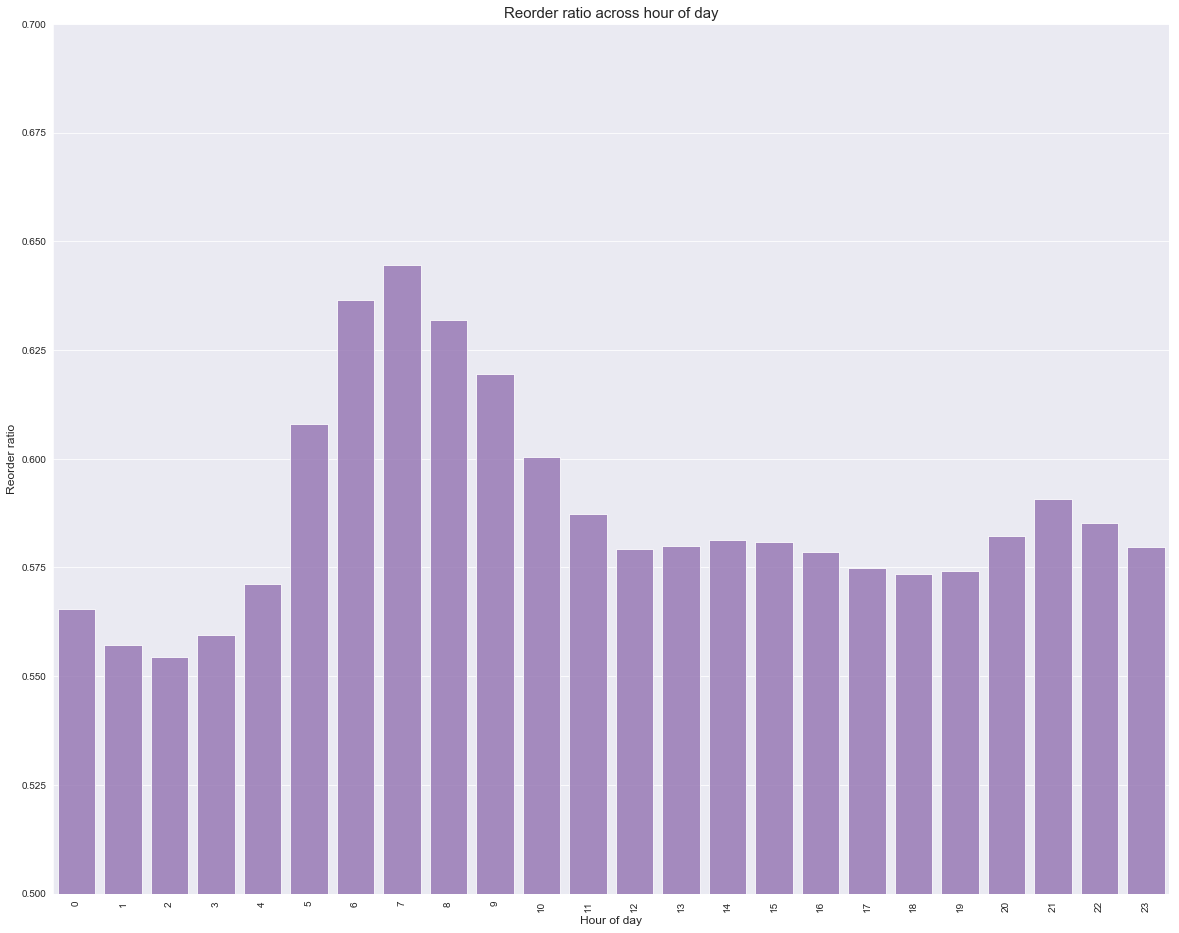

In [50]:
grouped_df = train_data.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(20,16))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

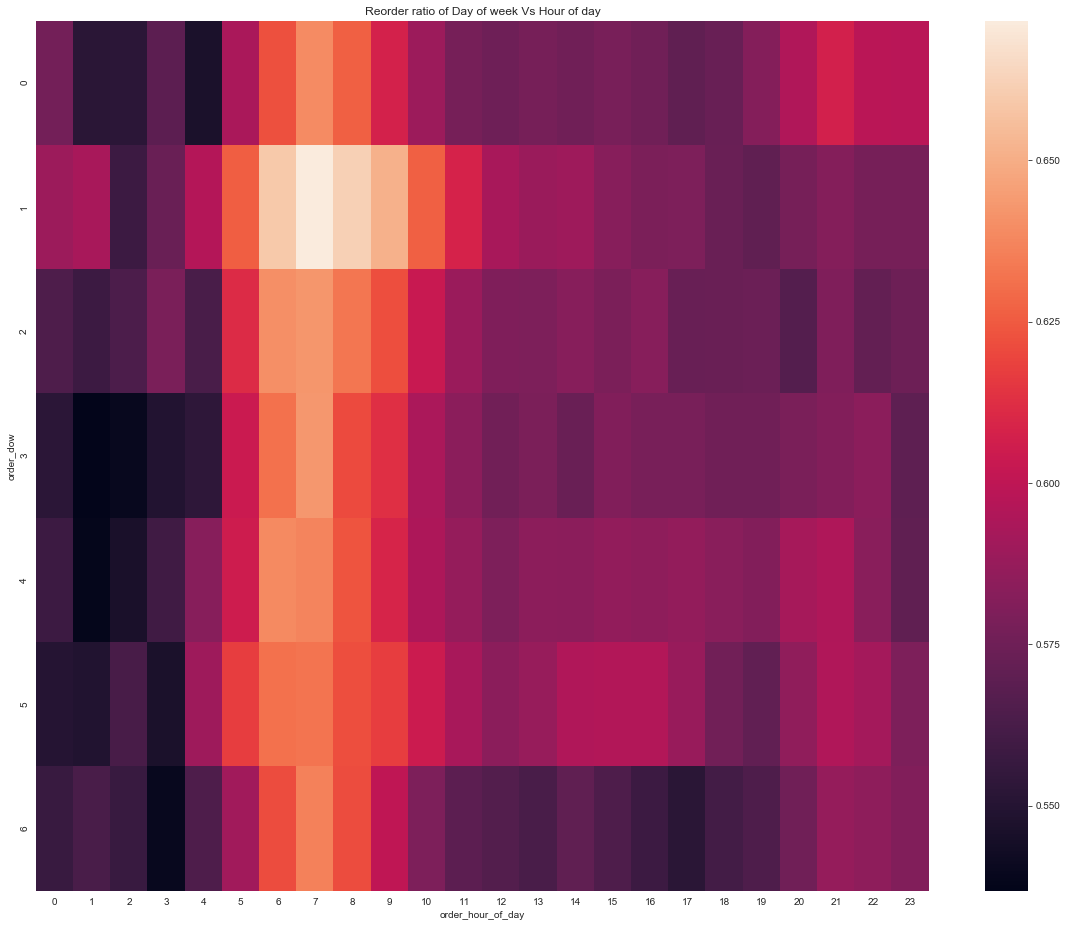

In [51]:
grouped_df = train_data.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(20,16))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

**Looks like reorder ratios are quite high during the early mornings compared to later half of the day.**

## How often do people reorder the same product?

In [52]:
reordered_products_train = pd.DataFrame({'count' : order_products_train.groupby( ['reordered'] ).size()}).reset_index()
new_col = reordered_products_train['count']/reordered_products_train['count'].sum()
reordered_products_train = reordered_products_train.assign(proportion = new_col )
reordered_products_train

,reordered,count,proportion
0,0,555793,0.401406
1,1,828824,0.598594


**Most products were reordered about 60% of the time**

## What are the most often reodered products?

In [53]:
most_reordered_product = pd.DataFrame({'product_id':order_products_train['product_id'],
                                     'proportion':order_products_train.groupby('product_id')['reordered'].mean(),
                                      'n': order_products_train.groupby('product_id')['reordered'].count()})
merged_reordered = pd.merge(products, pd.DataFrame(most_reordered_product, columns=['n', 'product_id', 'proportion']), 
                  left_on='product_id', right_index=True).reset_index()
merged_reordered.head()
merged_reordered = merged_reordered[merged_reordered['n'] > 40.0]
merged_reordered.sort_values('proportion', ascending=False).head()

,index,product_id,product_id_x,product_name,aisle_id,department_id,n,product_id_y,proportion
1728,1728,1729,1729,2% Lactose Free Milk,84,16,92.0,34,0.934783
20939,20939,20940,20940,Organic Low Fat Milk,84,16,368.0,43352,0.913043
12192,12192,12193,12193,100% Florida Orange Juice,98,7,59.0,29327,0.898305
31763,31763,31764,31764,Original Sparkling Seltzer Water Cans,115,7,45.0,24009,0.888889
21037,21037,21038,21038,Organic Spelt Tortillas,128,3,81.0,1934,0.888889


**It is mostly beverages that are reordered the most often.**

## What product do people put in their cart?

In [54]:
product_by_id_order = pd.DataFrame({'count':order_products_train.groupby(['product_id', 'add_to_cart_order']).size()})
new_col = product_by_id_order['count']/product_by_id_order['count'].sum()
product_by_id_order = product_by_id_order.assign(product_add_count=new_col)
product_by_id_order = product_by_id_order.reset_index()
product_by_id_order.head()

,product_id,add_to_cart_order,count,product_add_count
0,1,1,12,8.666657e-06
1,1,2,10,7.222214e-06
2,1,3,14,1.011110e-05
3,1,4,4,2.888886e-06
4,1,5,1,7.222214e-07


In [55]:
merged_product_reordered = pd.merge(products, product_by_id_order,
                                   on='product_id', how="left")
merged_product_reordered = pd.merge(merged_product_reordered, aisles,
                                   on='aisle_id', how="left")
merged_product_reordered = merged_product_reordered[merged_product_reordered['add_to_cart_order'] == 1]
merged_product_reordered = merged_product_reordered[merged_product_reordered['count'] > 10]
merged_product_reordered.sort_values('product_add_count', ascending=False, axis=0)

,product_id,product_name,aisle_id,department_id,add_to_cart_order,count,product_add_count,aisle
163163,24852,Banana,24,4,1.0,4605.0,0.003326,fresh fruits
86334,13176,Bag of Organic Bananas,24,4,1.0,3889.0,0.002809,fresh fruits
182621,27845,Organic Whole Milk,84,16,1.0,1144.0,0.000826,milk
314121,47766,Organic Avocado,24,4,1.0,995.0,0.000719,fresh fruits
138767,21137,Organic Strawberries,24,4,1.0,900.0,0.000650,fresh fruits
143879,21903,Organic Baby Spinach,123,4,1.0,869.0,0.000628,packaged vegetables fruits
310639,47209,Organic Hass Avocado,24,4,1.0,797.0,0.000576,fresh fruits
129296,19660,Spring Water,115,7,1.0,730.0,0.000527,water seltzer sparkling water
110228,16797,Strawberries,24,4,1.0,707.0,0.000511,fresh fruits
293539,44632,Sparkling Water Grapefruit,115,7,1.0,647.0,0.000467,water seltzer sparkling water


<BarContainer object of 2007 artists>

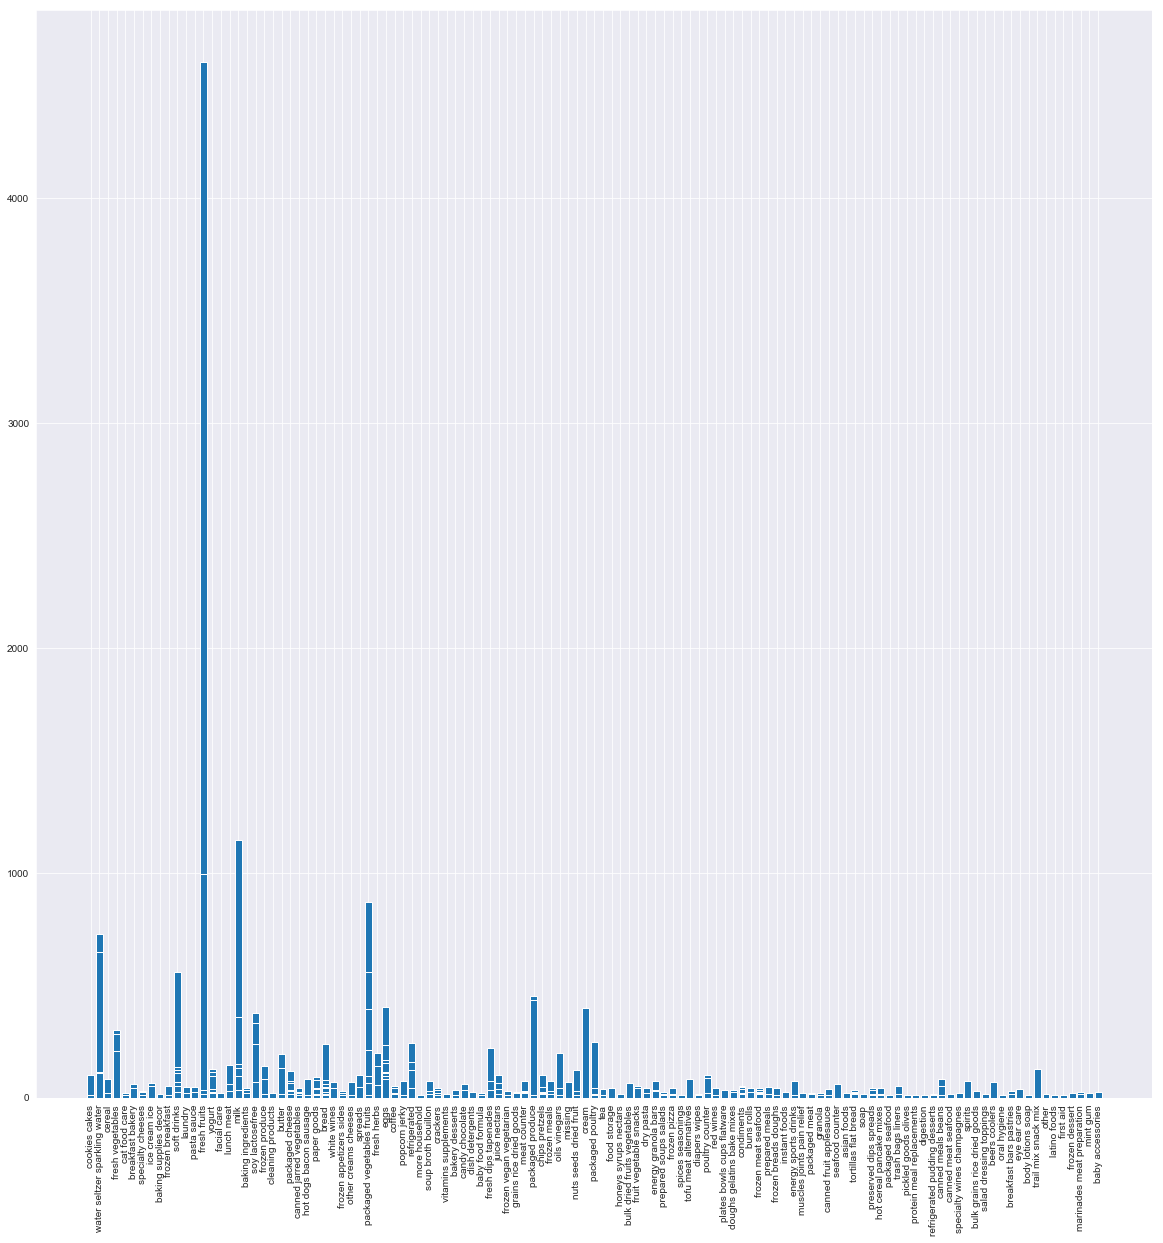

In [56]:
plt.figure(figsize=(20,20))
plt.xticks(rotation=90)
plt.bar(merged_product_reordered['aisle'], merged_product_reordered['count'])


**We can see that the trend is produce is usually added to the cart first, followed by dairy and other refridgerated items.**

## What is the association between time of last order and probability of reorder?

In [57]:
order_time_new = pd.merge(order_products_train, orders, on="order_id")
order_time_new.sort_values(by='days_since_prior_order_x')

,order_id,product_id,add_to_cart_order,reordered,user_id_x,eval_set_x,order_number_x,order_dow_x,order_hour_of_day_x,days_since_prior_order_x,user_id_y,eval_set_y,order_number_y,order_dow_y,order_hour_of_day_y,days_since_prior_order_y
925784,2284515,28385,4,1,154786,train,9,0,20,0.0,154786,train,9,0,20,0.0
761081,1873734,4920,7,1,65423,train,10,5,16,0.0,65423,train,10,5,16,0.0
761082,1873734,26497,8,1,65423,train,10,5,16,0.0,65423,train,10,5,16,0.0
761083,1873734,37011,9,1,65423,train,10,5,16,0.0,65423,train,10,5,16,0.0
761084,1873734,21621,10,1,65423,train,10,5,16,0.0,65423,train,10,5,16,0.0
761085,1873734,21267,11,1,65423,train,10,5,16,0.0,65423,train,10,5,16,0.0
761086,1873734,23909,12,1,65423,train,10,5,16,0.0,65423,train,10,5,16,0.0
761080,1873734,5865,6,1,65423,train,10,5,16,0.0,65423,train,10,5,16,0.0
761087,1873734,39877,13,1,65423,train,10,5,16,0.0,65423,train,10,5,16,0.0
761089,1873734,43999,15,1,65423,train,10,5,16,0.0,65423,train,10,5,16,0.0


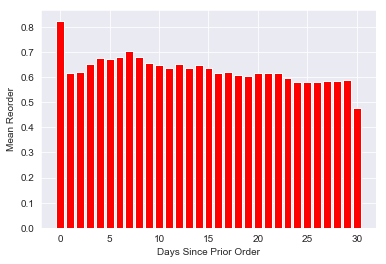

In [58]:
order_time_groupby_reorder = pd.DataFrame({'mean_reorder': order_time_new.groupby(['days_since_prior_order_x'])['reordered'].mean()})
order_time_groupby_reorder = order_time_groupby_reorder.reset_index()
plt.ylabel('Mean Reorder')
plt.xlabel('Days Since Prior Order')
plt.bar(order_time_groupby_reorder['days_since_prior_order_x'], 
        order_time_groupby_reorder['mean_reorder'], color='red')
plt.show()

**People who's last order was zero days ago were most likely to reorder. Perhaps this is because they forgot something on their initial order.**

**The next peak is at 7 days, and then the values decrease from there.**

## KNN To Determine If A Product is Reordered

In [59]:
train_data.columns

Index(['product_id', 'product_name', 'aisle_id', 'department_id', 'department',
       'order_id', 'add_to_cart_order', 'reordered', 'aisle', 'user_id',
       'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'add_to_cart_order_mod'],
      dtype='object')

In [180]:
train_data_10 = train_data_10 = train_data.sample(frac = 0.01) 

In [181]:
X = train_data_10[['product_id', 'aisle_id', 'department_id', 'order_id', 'add_to_cart_order', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]

In [182]:
y = train_data_10['reordered']

In [183]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [184]:
def train_test_rmse(df, feature_cols):
    X = df[feature_cols]
    y_1= df.reordered
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_1, test_size = .3)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [185]:
train_test_rmse(train_data, ['product_id', 'aisle_id', 'department_id', 'order_id', 'add_to_cart_order', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'])

0.4578044313427597

In [66]:
i_ = []
w_ = []
for i in range (1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred_class = knn.predict(X_test)
    w = metrics.accuracy_score(y_test, y_pred_class)
    print(i)
    print(w)
    i_.append(i)
    w_.append(w)

1
0.517629213067446
2
0.474848002762465
3
0.5256082972609666
4
0.4937906199514102
5
0.5322061489511266
6
0.5062710422139184
7
0.5350796058554392
8
0.5129675533686041
9
0.5386190141453008
10
0.519084440169201
11
0.5414801386165476
12
0.5256452945601637
13
0.545377187465315
14
0.5294560163774711
15
0.5472887145905015
16
0.5334270598246328
17
0.5501128417625514
18
0.5382613735863948
19
0.5524190067458409
20
0.5417144548447963
21
0.5539235635798587
22
0.5445385820168461
23
0.5563530528938054
24
0.5477450146139332
25
0.5584865638141749
26
0.5495825471407254
27
0.5597691368530098
28
0.5511241012739403
29
0.5617669910096563


(0, 31)

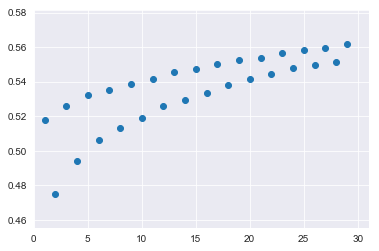

In [177]:
plt.scatter(i_, w_)
plt.xlim(0, 31)

In [186]:
knn = KNeighborsClassifier(n_neighbors=29)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=29, p=2,
           weights='uniform')

In [187]:
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.5602994314748356


## Random Tree Model to Determine Probability of Reorder

In [70]:
train_data_10 = train_data.sample(frac = 0.01)

In [71]:
# feature_cols = train_data[['product_id', 'aisle_id', 'department_id', 'order_id', 'add_to_cart_order', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]

X = train_data_10[['product_id', 'aisle_id', 'department_id', 'order_id', 'add_to_cart_order', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
y = train_data_10.reordered

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [72]:
X

,product_id,aisle_id,department_id,order_id,add_to_cart_order,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
27858725,31808,77,7,2827256,5,189646,31,6,17,6.0
2925536,36326,85,17,1477886,21,77256,15,1,20,17.0
12154513,18089,57,14,913060,6,138126,96,0,22,2.0
4515126,4451,84,16,2585986,1,192095,5,1,22,14.0
21360202,31268,85,17,2561517,8,89511,35,4,10,3.0
2624313,18207,37,1,2140215,32,11422,4,5,18,23.0
27934077,30879,121,14,3029787,3,11262,6,4,10,3.0
785505,7533,120,16,49578,18,111487,6,6,13,7.0
10140935,6173,110,13,2640539,42,153050,13,0,13,30.0
1742459,34969,83,4,2375737,2,82455,2,3,16,5.0


In [73]:
# Set a seed for reproducibility.
np.random.seed(123)

# Create ten bootstrap samples (which will be used to select rows from the DataFrame).
samples = [np.random.choice(a=X_train.shape[0], size=X_train.shape[0], replace=True) for _ in range(1, 11)]
samples

[array([249342, 277869,  28030, ...,  15694, 174956, 241929]),
 array([231063, 170914,  85759, ...,  89374, 106049,  17325]),
 array([246604, 231293, 119637, ...,  65383, 164089, 206012]),
 array([247748, 209295, 221725, ..., 236005, 302506, 134453]),
 array([268722, 131549, 301881, ..., 251303, 133778, 300571]),
 array([254131, 242994,  39300, ..., 303530,  71498, 185153]),
 array([ 86469, 210964,  10099, ..., 165054, 232876,  38128]),
 array([267099,  48458,  65468, ..., 109255,  71854,  92533]),
 array([293180,  46098, 210617, ...,   5726, 189775, 262723]),
 array([213588, 174837, 239278, ..., 234790,  16326, 133084])]

In [74]:
# Show the rows for the first decision tree.
X_train.iloc[samples[0], :].head()
#Not sure why the indices are randomized, don't refelct the arrays we have....

,product_id,aisle_id,department_id,order_id,add_to_cart_order,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
25936546,23540,64,7,2376867,2,30588,34,2,9,9.0
15671490,46979,83,4,2660553,9,124369,20,5,15,25.0
2752108,22474,78,19,2879652,5,40742,14,0,14,29.0
17768470,28359,104,13,1018513,1,96023,27,0,21,0.0
29433452,11742,67,20,2913578,2,31416,34,3,9,6.0


In [75]:
from sklearn.tree import DecisionTreeRegressor

# Grow each tree deep.
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# List for storing predicted price from each tree:
predictions = []

# Grow one tree for each bootstrap sample and make predictions on testing data.
for sample in samples:
    X_train_sample = X_train.iloc[sample,]
    y_train_sample = y_train.iloc[sample,]
    treereg.fit(X_train_sample, y_train_sample)
    y_pred = treereg.predict(X_test)
    predictions.append(y_pred)

In [76]:
predictions = np.array(predictions)
predictions[:2]

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 1., 0., 1.]])

In [77]:
# Average predictions.
np.mean(predictions, axis=0)

array([0.9, 0.5, 0.7, ..., 0.6, 0.5, 0.3])

In [78]:
# Calculate RMSE.
from sklearn import metrics
y_pred = np.mean(predictions, axis=0)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

0.44463893882214417

In [79]:
# Instruct BaggingRegressor to use DecisionTreeRegressor as the "base estimator."
from sklearn.ensemble import BaggingRegressor
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, 
                          bootstrap=True, oob_score=True, random_state=1)

In [80]:
# Fit and predict.
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([0.81 , 0.736, 0.942, ..., 0.81 , 0.494, 0.458])

In [81]:
# Calculate RMSE.
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

0.4245248585547042

In [82]:
# # feature_cols = train_data[['product_id', 'aisle_id', 'department_id', 'order_id', 'add_to_cart_order', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]

# X = train_data[['product_id', 'aisle_id', 'department_id', 'order_id', 'add_to_cart_order', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
# y = train_data.reordered

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [83]:
# # Set a seed for reproducibility.
# np.random.seed(123)

# # Create ten bootstrap samples (which will be used to select rows from the DataFrame).
# samples = [np.random.choice(a=X_train.shape[0], size=X_train.shape[0], replace=True) for _ in range(1, 11)]
# samples

In [84]:
# # Set a seed for reproducibility.
# np.random.seed(123)

# # Create ten bootstrap samples (which will be used to select rows from the DataFrame).
# samples = [np.random.choice(a=X_train.shape[0], size=X_train.shape[0], replace=True) for _ in range(1, 11)]
# samples

In [85]:
# from sklearn.tree import DecisionTreeRegressor

# # Grow each tree deep.
# treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# # List for storing predicted price from each tree:
# predictions = []

# # Grow one tree for each bootstrap sample and make predictions on testing data.
# for sample in samples:
#     X_train_sample = X_train.iloc[sample,]
#     y_train_sample = y_train.iloc[sample,]
#     treereg.fit(X_train_sample, y_train_sample)
#     y_pred = treereg.predict(X_test)
#     predictions.append(y_pred)

In [86]:
# predictions = np.array(predictions)
# predictions[:2]

In [87]:
# # Average predictions.
# np.mean(predictions, axis=0)

In [88]:
# # Calculate RMSE.
# from sklearn import metrics
# y_pred = np.mean(predictions, axis=0)
# np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [89]:
# # Instruct BaggingRegressor to use DecisionTreeRegressor as the "base estimator."
# from sklearn.ensemble import BaggingRegressor
# bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, 
#                           bootstrap=True, oob_score=True, random_state=1)

In [90]:
# # Fit and predict.
# bagreg.fit(X_train, y_train)
# y_pred = bagreg.predict(X_test)
# y_pred

In [91]:
# # Calculate RMSE.
# np.sqrt(metrics.mean_squared_error(y_test, y_pred))

## Preprocessing
In this section, I used a model that was created by a Kaggle competition participant, but changed a few variables to better fit the model I created earlier to see if I couuld get a better accuracy score. We will extract key features that we can use to build our model, analyze their significance, and build a RandomForest model to predict what items will be ordered next. 

Many of these functions and the idea to use the RandomForest came from the help of the Machine Learning group at my office and the original Kaggle notebook. 

In [92]:
prior = pd.read_csv('order_products__prior.csv')
train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')

**First, we'll get a list of the users in both the test and the train data, and print the number of users in each set.**

In [93]:
test_user_ids = orders[orders.eval_set == "test"].user_id
orig_train_user_ids = orders[orders.eval_set == "train"].user_id

users_in_test_set = len(test_user_ids.index)
users_in_train_set = len(orig_train_user_ids.index)

print("Users in test set: {0}.".format(users_in_test_set))
print("Users in train set: {0}.".format(users_in_train_set))

print("\nSplit training into 80:20\n")

users_in_val_set = math.floor(users_in_train_set / 5)
users_in_train_set = users_in_train_set - users_in_val_set

print("Users in train set: {0}".format(users_in_train_set))
print("Users in validation set: {0}".format(users_in_val_set))

Users in test set: 75000.
Users in train set: 131209.

Split training into 80:20

Users in train set: 104968
Users in validation set: 26241


**Then we'll make sure that the numbers of users in the created training and validation set are the same.**

In [94]:
val_user_ids = orig_train_user_ids[0:users_in_val_set]
new_train_user_ids = orig_train_user_ids[users_in_val_set:]

actual_users_in_val_set = len(val_user_ids.index)
actual_users_in_train_set = len(new_train_user_ids.index)

print("Users in new train set: {0} - Match: {1}".format(actual_users_in_train_set, users_in_train_set==actual_users_in_train_set))
print("Users in new validation set: {0} - Match: {1}".format(actual_users_in_val_set, users_in_val_set==actual_users_in_val_set))

Users in new train set: 104968 - Match: True
Users in new validation set: 26241 - Match: True


**We'll export those data sets into csv files to be called again later, and split the original DataFrames accordingly.**

In [95]:
orders[orders.user_id.isin(test_user_ids)].to_csv('test_set_orders.csv', index=False)
orders[orders.user_id.isin(new_train_user_ids)].to_csv('train_set_orders.csv', index=False)
orders[orders.user_id.isin(val_user_ids)].to_csv('val_set_orders.csv', index=False)

In [96]:
val_orders = pd.read_csv('val_set_orders.csv')
train[train.order_id.isin(val_orders.order_id)].to_csv('val_set_last_order_products.csv', index=False)
train_orders = pd.read_csv('train_set_orders.csv')
train[train.order_id.isin(train_orders.order_id)].to_csv('train_set_last_order_products.csv', index=False)

# split the prior orders according to training, validation and test set orders.
test_orders = pd.read_csv('test_set_orders.csv')
prior[prior.order_id.isin(test_orders.order_id)].to_csv('test_set_prior_order_products.csv', index=False)
prior[prior.order_id.isin(val_orders.order_id)].to_csv('val_set_prior_order_products.csv', index=False)
prior[prior.order_id.isin(train_orders.order_id)].to_csv('train_set_prior_order_products.csv', index=False)

**We need to write a few functions. The first will load the datasets into memory, the second will retrieve orders and products for a specific customer, and the third to plot common charts.**

In [97]:
def load_orders(path):
    def convert_eval_set(value):
        if 'prior' == value:
            return np.uint8(1)
        elif 'train' == value:
            return np.uint8(2)
        else:
            return np.uint8(3) # 'test'

    def convert_days_since_prior_order(value):
        # 30 is the maximum value
        if '' == value:
            return np.int8(-1)
        else:
            return np.int8(np.float(value))

    orders = pd.read_csv(path,
                         dtype={'order_id': np.uint32,
                                'user_id': np.uint32,
                                'order_number': np.uint8,
                                'order_dow': np.uint8,
                                'order_hour_of_day': np.uint8},
                         converters={'eval_set':convert_eval_set,
                                     'days_since_prior_order':convert_days_since_prior_order})

    orders = orders.astype({'eval_set': np.uint8, 
                            'days_since_prior_order': np.int8})
    
    return orders

def load_orders_prods(path):
    return pd.read_csv(path, dtype={'order_id': np.uint32,
                                    'product_id': np.uint32,
                                    'add_to_cart_order': np.uint8,
                                    'reordered': np.uint8})

def load_products(path):
    return pd.read_csv(path, dtype={'product_id': np.uint16,
                                    'aisle_id': np.uint8,
                                    'department_id': np.uint8})

def load_aisles(path):
    return pd.read_csv(path, dtype={'aisle_id': np.uint8})

def load_depts(path):
    return pd.read_csv(path, dtype={'department_id': np.uint8})



def GetOrdersList(user_id, exclude_first_order=False):
    print("Retrieving orders for user ID: {0}".format(user_id))
    if exclude_first_order:
        return orders[(orders.user_id == user_id) & (orders.eval_set == 'prior') & (orders.order_number > 1)].sort_values('order_number', ascending=True).order_id
    else:
        return orders[(orders.user_id == user_id) & (orders.eval_set == 'prior')].sort_values('order_number', ascending=True).order_id

def GetProductsForOrder(order_id, prior_orders=True):
    if prior_orders:
        return prior_prods[prior_prods.order_id == order_id]
    else:
        return last_prods[last_prods.order_id == order_id]
    
def GetProductsForAllOrdersByCust(user_id, unique_products_only=False, exclude_first_order=False):
    orders_list = GetOrdersList(user_id, exclude_first_order)
    if unique_products_only:
        return prior_prods[prior_prods.order_id.isin(orders_list)].product_id.unique()
    else:
        return prior_prods[prior_prods.order_id.isin(orders_list)]



def plot_scatter(ax, x, y, title, x_label, ylim=[], fit_Line=True):
    if fit_Line:
        fit = np.polyfit(x, y, deg=1)
        ax.plot(x, fit[0] * x + fit[1], color='red')
    
    ax.scatter(x,y,alpha=0.75);
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.grid(b=True, color='0.75', alpha=0.5)
    if 1 == len(ylim):
        ax.set_ylim(bottom=ylim[0])
    elif 2 == len(ylim):
        ax.set_ylim(ylim)

def printmd(string):
    display(Markdown(string))

In [99]:
orders = load_orders('train_set_orders.csv')

**Now we need to get a list of user IDs and order history.**

In [100]:
customers = orders.user_id.unique()
customers_count = len(customers)


prior_orders_only = orders[(1 == orders.eval_set)]
final_orders_only = orders[(1 != orders.eval_set)]
orders_count = len(prior_orders_only.order_id)

overall_mean_orders_count = orders_count / customers_count

**Graph showing number of orders per customer.**

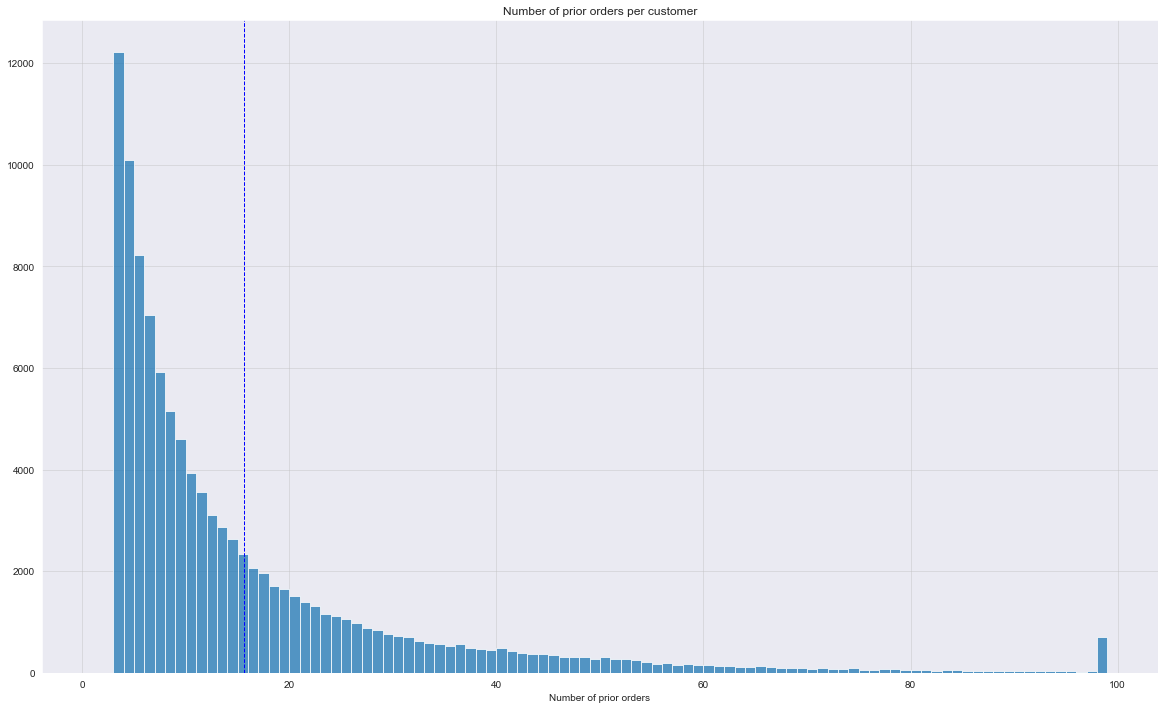

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

count_of_orders_per_customer = prior_orders_only.groupby('user_id').order_id.count()
ax.hist(x=count_of_orders_per_customer, 
        bins=range(1, count_of_orders_per_customer.max()+1, 1),
        alpha=0.75);
ax.set_title("Number of prior orders per customer")
ax.set_xlabel('Number of prior orders')
ax.grid(b=True, color='0.75', alpha=0.5)
ax.axvline(overall_mean_orders_count, color='b', linestyle='dashed', linewidth=1);

**What was the mean number of days between orders?**

In [102]:
overall_mean_days_since_last_order = prior_orders_only[prior_orders_only.order_number > 1].days_since_prior_order.mean()
printmd("Mean number of days since last order for all customers: **{0:0.1f}** days".format(overall_mean_days_since_last_order))

Mean number of days since last order for all customers: **10.7** days

**Days since last order.**

In [103]:
# min_DSLO_per_customer = prior_orders_only[prior_orders_only.order_number > 1].groupby('user_id').days_since_prior_order.min()
# mean_DSLO_per_customer = prior_orders_only[prior_orders_only.order_number > 1].groupby('user_id').days_since_prior_order.mean()
# max_DSLO_per_customer = prior_orders_only[prior_orders_only.order_number > 1].groupby('user_id').days_since_prior_order.max()

In [106]:
orders_prods = load_orders_prods('train_set_prior_order_products.csv')

**What was the average number of products bought by each person?**

In [107]:
orders_length = orders_prods.groupby('order_id').add_to_cart_order.max()
orders_length = orders_length.reset_index()
orders_length.rename(columns={'add_to_cart_order': 'total_items_ordered'}, inplace=True)

overall_mean_order_length = orders_length.total_items_ordered.mean()
printmd("Overall mean number of items ordered per order: **{0:0.1f}** items".format(overall_mean_order_length))

Overall mean number of items ordered per order: **10.1** items

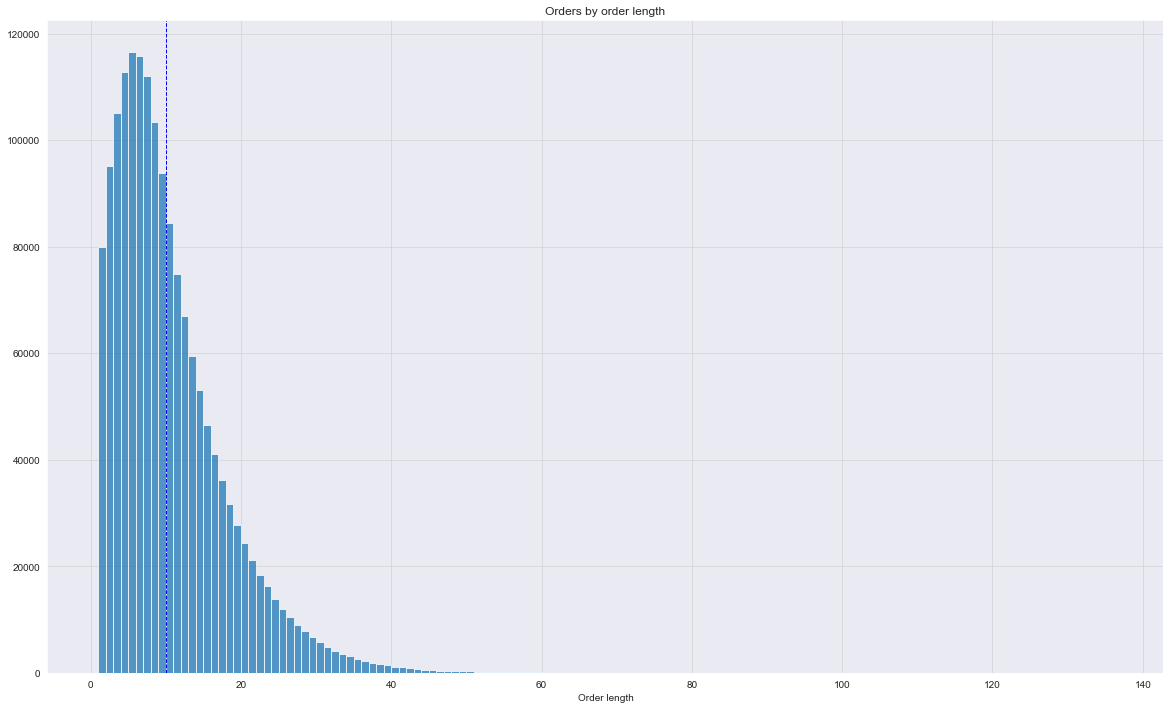

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

ax.hist(orders_length.total_items_ordered, bins=range(1, orders_length.total_items_ordered.max(), 1), alpha=0.75);
ax.set_title("Orders by order length")
ax.set_xlabel('Order length')
ax.grid(b=True, color='0.75', alpha=0.5)
ax.axvline(overall_mean_order_length, color='b', linestyle='dashed', linewidth=1);

In [109]:
orders_length_merge = pd.merge(orders_length, prior_orders_only, on='order_id')
orders_length_merge['order_id'] = orders_length_merge.order_id.astype(np.uint32)

mean_order_length_per_customer = orders_length_merge.groupby('user_id').total_items_ordered.mean().reset_index()
mean_order_length_per_DSLO = orders_length_merge.groupby('days_since_prior_order').total_items_ordered.mean().reset_index()
mean_order_length_per_DoW = orders_length_merge.groupby('order_dow').total_items_ordered.mean().reset_index()
mean_order_length_per_Hour = orders_length_merge.groupby('order_hour_of_day').total_items_ordered.mean().reset_index()

**Now that we've looked at those things, we will want to create a ration or reordered items to total items ordered, excluding the first orders.**

In [110]:
orders_reorder_ratio = orders_prods.groupby('order_id').reordered.sum() / orders_length.set_index('order_id').total_items_ordered

orders_reorder_ratio = pd.merge(orders_reorder_ratio.reset_index(), prior_orders_only[prior_orders_only.order_number > 1], on='order_id')
orders_reorder_ratio.rename(columns={0: 'reorder_ratio'}, inplace=True)
orders_reorder_ratio['order_id'] = orders_reorder_ratio.order_id.astype(np.uint32)

overall_mean_reorder_ratio = orders_reorder_ratio.reorder_ratio.mean()
printmd("Overall mean reorder ratio: **{0:0.2f}**".format(overall_mean_reorder_ratio))

Overall mean reorder ratio: **0.64**

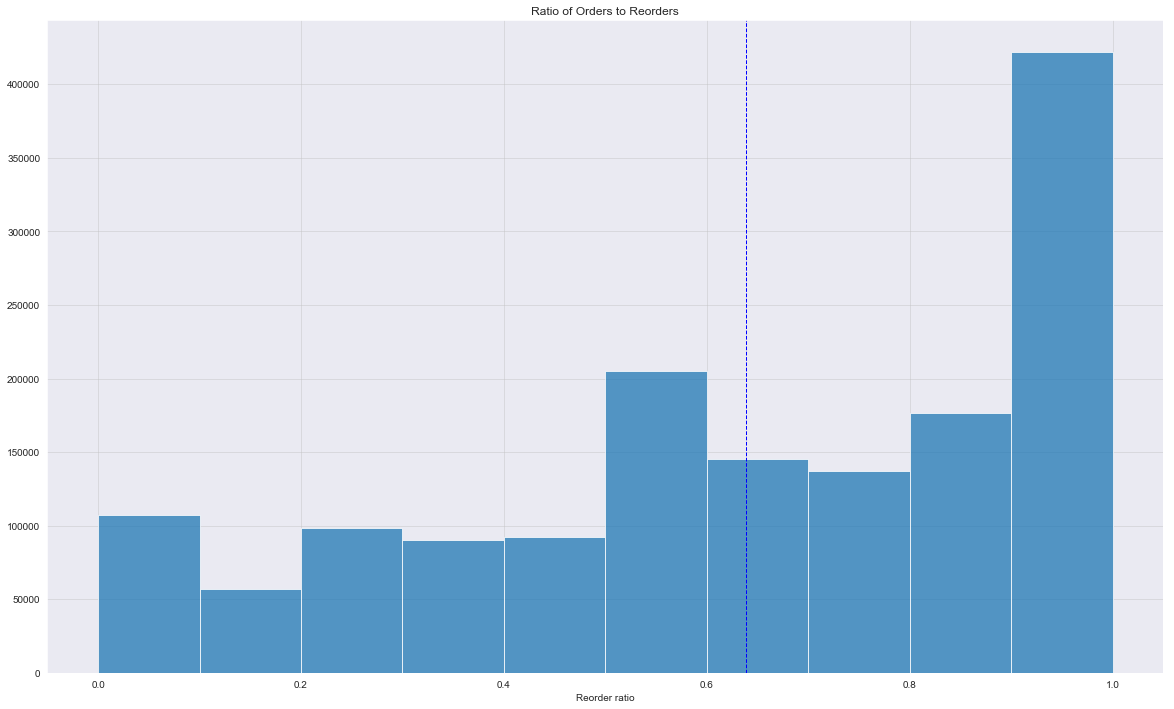

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

ax.hist(orders_reorder_ratio.reorder_ratio, alpha=0.75);
ax.set_title("Ratio of Orders to Reorders")
ax.set_xlabel('Reorder ratio')
ax.grid(b=True, color='0.75', alpha=0.5)
ax.axvline(overall_mean_reorder_ratio, color='b', linestyle='dashed', linewidth=1);

**Create groups.**

In [112]:
# mean_reorder_ratio_per_user = orders_reorder_ratio.groupby('user_id').reorder_ratio.mean().reset_index()
# mean_reorder_ratio_per_DSLO = orders_reorder_ratio.groupby('days_since_prior_order').reorder_ratio.mean().reset_index()
# mean_reorder_ratio_per_DoW = orders_reorder_ratio.groupby('order_dow').reorder_ratio.mean().reset_index()
# mean_reorder_ratio_per_Hour = orders_reorder_ratio.groupby('order_hour_of_day').reorder_ratio.mean().reset_index()

In [113]:
products = load_products('products.csv')
aisles = load_aisles('aisles.csv')
depts = load_depts('departments.csv')

**Number of different products ordered.**

In [114]:
count_diff_products_ordered = len(orders_prods.product_id.unique())
printmd("Different products ordered: **{0}**".format(count_diff_products_ordered))

Different products ordered: **49188**

In [115]:
# overall_product_probabilities = orders_prods.groupby('product_id').reordered.sum() + 1
# overall_product_probabilities = overall_product_probabilities / overall_product_probabilities.sum()
# overall_product_probabilities.sort_values(inplace=True, ascending=False)
# overall_product_probabilities = overall_product_probabilities.reset_index()

**Load in the CSVs we made.**

In [116]:
orders = load_orders('val_set_orders.csv')
orders_prods = load_orders_prods('val_set_prior_order_products.csv')
products = load_products('products.csv')
aisles = load_aisles('aisles.csv')
depts = load_depts('departments.csv')

**Split up between final orders and prior orders.**

In [117]:
prior_orders_only = orders[(1 == orders.eval_set)]
final_orders_only = orders[(1 != orders.eval_set)]

**Create a DataFrame that computes the mean order length, reorder ration, and drops the first order per customer, similar to previous ones.**

In [118]:
orders_length = orders_prods.groupby('order_id').add_to_cart_order.max().reset_index()
orders_length.rename(columns={'add_to_cart_order': 'total_items_ordered'}, inplace=True)
orders_length_merge = orders_length.merge(prior_orders_only[['order_id','user_id']], on='order_id')
orders_length_merge['order_id'] = orders_length_merge.order_id.astype(np.uint32)

mean_order_length_per_customer = orders_length_merge.groupby('user_id').total_items_ordered.mean().round().reset_index()
mean_order_length_per_customer['user_id'] = mean_order_length_per_customer.user_id.astype(np.uint32)
mean_order_length_per_customer.rename(columns={'total_items_ordered': 'mean_order_length'}, inplace=True)
mean_order_length_per_customer['mean_order_length'] = mean_order_length_per_customer.mean_order_length.astype(np.uint16)

del orders_length_merge

orders_reorder_ratio = orders_prods.groupby('order_id').reordered.sum() / orders_length.set_index('order_id').total_items_ordered
orders_reorder_ratio = orders_reorder_ratio.reset_index()

del orders_length

orders_reorder_ratio = orders_reorder_ratio.merge(prior_orders_only[prior_orders_only.order_number > 1], on='order_id')
orders_reorder_ratio.rename(columns={0: 'reorder_ratio'}, inplace=True)
orders_reorder_ratio['order_id'] = orders_reorder_ratio.order_id.astype(np.uint32)

mean_reorder_ratio_per_customer = orders_reorder_ratio.groupby('user_id').reorder_ratio.mean().reset_index()
mean_reorder_ratio_per_customer['user_id'] = mean_reorder_ratio_per_customer.user_id.astype(np.uint32)
mean_reorder_ratio_per_customer.rename(columns={'reorder_ratio': 'mean_reorder_ratio'}, inplace=True)
mean_reorder_ratio_per_customer['mean_reorder_ratio'] = mean_reorder_ratio_per_customer.mean_reorder_ratio.astype(np.float16)

del orders_reorder_ratio

In [119]:
mean_order_length_per_customer.head()

,user_id,mean_order_length
0,1,6
1,2,14
2,5,9
3,7,10
4,8,16


In [120]:
mean_reorder_ratio_per_customer.head()

,user_id,mean_reorder_ratio
0,1,0.784180
1,2,0.482422
2,5,0.503906
3,7,0.793945
4,8,0.458984


**Create new grouped DataFrames to calculate probability of reorder.**

In [121]:
flat_order_prods = orders_prods.merge(prior_orders_only, on='order_id')
flat_order_prods = flat_order_prods.merge(products[['product_id','aisle_id','department_id']], on='product_id')
flat_order_prods.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
0,6,40462,1,0,22352,1,4,1,12,30,31,7
1,21553,40462,1,1,31136,1,13,1,13,25,31,7
2,208931,40462,1,1,7137,1,4,2,9,6,31,7
3,424301,40462,1,1,31136,1,7,2,11,12,31,7
4,455382,40462,20,0,33665,1,2,0,19,7,31,7


In [122]:
product_probs_per_cust = flat_order_prods.groupby(['user_id','product_id']).reordered.sum() + 1
product_probs_per_cust = product_probs_per_cust / product_probs_per_cust.reset_index().groupby(['user_id']).reordered.sum()
product_probs_per_cust = product_probs_per_cust.reset_index()
product_probs_per_cust['user_id'] = product_probs_per_cust.user_id.astype(np.uint32)
product_probs_per_cust['product_id'] = product_probs_per_cust.product_id.astype(np.uint32)
product_probs_per_cust.rename(columns={'reordered': 'prob'}, inplace=True)
product_probs_per_cust.head()

,user_id,product_id,prob
0,1,196,0.169492
1,1,10258,0.152542
2,1,10326,0.016949
3,1,12427,0.169492
4,1,13032,0.050847


In [123]:
aisle_probs_per_cust = flat_order_prods.groupby(['user_id','aisle_id']).reordered.sum() + 1
aisle_probs_per_cust = aisle_probs_per_cust / aisle_probs_per_cust.reset_index().groupby(['user_id']).reordered.sum()
aisle_probs_per_cust = aisle_probs_per_cust.reset_index()
aisle_probs_per_cust['user_id'] = aisle_probs_per_cust.user_id.astype(np.uint32)
aisle_probs_per_cust['aisle_id'] = aisle_probs_per_cust.aisle_id.astype(np.uint8)
aisle_probs_per_cust.rename(columns={'reordered': 'prob'}, inplace=True)
aisle_probs_per_cust.head()

,user_id,aisle_id,prob
0,1,21,0.150943
1,1,23,0.207547
2,1,24,0.037736
3,1,45,0.018868
4,1,53,0.037736


In [124]:
dept_probs_per_cust = flat_order_prods.groupby(['user_id','department_id']).reordered.sum() + 1
dept_probs_per_cust = dept_probs_per_cust / dept_probs_per_cust.reset_index().groupby(['user_id']).reordered.sum()
dept_probs_per_cust = dept_probs_per_cust.reset_index()
dept_probs_per_cust['user_id'] = dept_probs_per_cust.user_id.astype(np.uint32)
dept_probs_per_cust['department_id'] = dept_probs_per_cust.department_id.astype(np.uint8)
dept_probs_per_cust.rename(columns={'reordered': 'prob'}, inplace=True)
dept_probs_per_cust.head()

,user_id,department_id,prob
0,1,4,0.041667
1,1,7,0.250000
2,1,13,0.020833
3,1,14,0.062500
4,1,16,0.187500


**Days since first order per customer.**

In [125]:
DSFO_popc = prior_orders_only.copy()

DSFO_popc['DSFO'] = DSFO_popc.groupby(['user_id']).days_since_prior_order.cumsum() + 1
DSFO_popc['DSFO'] = DSFO_popc.DSFO.astype(np.uint16)
del DSFO_popc['eval_set']
del DSFO_popc['order_number']
del DSFO_popc['order_dow']
del DSFO_popc['order_hour_of_day']
del DSFO_popc['days_since_prior_order']
DSFO_popc.head()

,order_id,user_id,DSFO
0,2539329,1,0
1,2398795,1,15
2,473747,1,36
3,2254736,1,65
4,431534,1,93


In [126]:
max_DSFO_pc = DSFO_popc.groupby(['user_id']).DSFO.max().reset_index()
max_DSFO_pc.rename(columns={'DSFO': 'max_DSFO'}, inplace=True)
max_DSFO_pc.head()

,user_id,max_DSFO
0,1,176
1,2,198
2,5,40
3,7,203
4,8,60


In [127]:
orders_pc = prior_orders_only.groupby('user_id').order_number.max().reset_index()
orders_pc['user_id'] = orders_pc.user_id.astype(np.uint32)
orders_pc.rename(columns={'order_number': 'number_of_orders'}, inplace=True)
orders_pc.head()

,user_id,number_of_orders
0,1,10
1,2,14
2,5,4
3,7,20
4,8,3


**New DataFrame that we'll use for our model, showing the days since the first order per product, per order, per customer.**|

In [128]:
props_pppc = flat_order_prods[['order_id','product_id','aisle_id','department_id','reordered']].merge(DSFO_popc, on="order_id")

props_pppc = props_pppc.groupby(['user_id','product_id']).agg({'DSFO': [min, max],
                                                               'reordered': sum,
                                                               'aisle_id': max,
                                                               'department_id': max})

props_pppc = props_pppc.reset_index()
props_pppc.columns = ['_'.join(col).strip('_') for col in props_pppc.columns.values]

props_pppc = props_pppc.merge(max_DSFO_pc, on='user_id')
props_pppc = props_pppc.merge(orders_pc, on='user_id')

props_pppc['user_id'] = props_pppc.user_id.astype(np.uint32)
props_pppc['product_id'] = props_pppc.product_id.astype(np.uint32)

props_pppc.rename(columns={'aisle_id_max': 'aisle_id'}, inplace=True)
props_pppc.rename(columns={'department_id_max': 'department_id'}, inplace=True)

props_pppc = props_pppc.merge(product_probs_per_cust, on=['user_id','product_id'])
props_pppc.rename(columns={'prob': 'prod_prob'}, inplace=True)

props_pppc = props_pppc.merge(aisle_probs_per_cust, on=['user_id','aisle_id'])
props_pppc.rename(columns={'prob': 'aisle_prob'}, inplace=True)

props_pppc = props_pppc.merge(dept_probs_per_cust, on=['user_id','department_id'])
props_pppc.rename(columns={'prob': 'department_prob'}, inplace=True)

props_pppc = props_pppc.merge(final_orders_only[['user_id','days_since_prior_order']], on="user_id")
props_pppc.rename(columns={'days_since_prior_order': 'last_order_DSLO'}, inplace=True)

props_pppc['reorder_prob'] = (props_pppc['reordered_sum'] + 1) / props_pppc['number_of_orders']

props_pppc['recency_prob'] = (props_pppc['DSFO_max'] / (props_pppc['max_DSFO'] + props_pppc['last_order_DSLO'])).where(props_pppc['last_order_DSLO'] > 0, 0)

props_pppc['mean_DTOP'] = ((props_pppc['DSFO_max'] - props_pppc['DSFO_min']) / props_pppc['reordered_sum']).where(props_pppc['DSFO_max'] > props_pppc['DSFO_min'], props_pppc['DSFO_max'])
props_pppc['mean_DTOP'] = props_pppc.mean_DTOP.astype(np.float16)

props_pppc['DTOP_prob'] = ((props_pppc['max_DSFO'] + props_pppc['last_order_DSLO']) - props_pppc['DSFO_max']) / props_pppc['mean_DTOP']

props_pppc['DTOP_prob'].fillna(0, inplace=True)

props_pppc['DTOP_prob'] = props_pppc['DTOP_prob'].clip(lower=0, upper=0.9999999)

props_pppc['prod_prob'] = props_pppc.prod_prob.astype(np.float16)
props_pppc['aisle_prob'] = props_pppc.aisle_prob.astype(np.float16)
props_pppc['department_prob'] = props_pppc.department_prob.astype(np.float16)
props_pppc['reorder_prob'] = props_pppc.reorder_prob.astype(np.float16)
props_pppc['recency_prob'] = props_pppc.recency_prob.astype(np.float16)
props_pppc['DTOP_prob'] = props_pppc.DTOP_prob.astype(np.float16)

props_pppc['reordered'] = 0
props_pppc['reordered'] = props_pppc.reordered.astype(np.uint8)

In [129]:
del props_pppc['DSFO_min']
del props_pppc['DSFO_max']
del props_pppc['reordered_sum']
del props_pppc['aisle_id']
del props_pppc['department_id']
del props_pppc['max_DSFO']
del props_pppc['number_of_orders']
del props_pppc['last_order_DSLO']
del props_pppc['mean_DTOP']

props_pppc.head()

,user_id,product_id,prod_prob,aisle_prob,department_prob,reorder_prob,recency_prob,DTOP_prob,reordered
0,1,196,0.169434,0.22644,0.250000,1.000000,0.926270,0.715820,0
1,1,46149,0.050842,0.22644,0.250000,0.300049,0.926270,0.933105,0
2,1,10258,0.152588,0.16980,0.395752,0.899902,0.926270,0.695801,0
3,1,12427,0.169434,0.20752,0.395752,1.000000,0.926270,0.715820,0
4,1,26088,0.033905,0.20752,0.395752,0.199951,0.078918,1.000000,0


In [135]:
last_reordered_prods = load_orders_prods('val_set_last_order_products.csv')
last_reordered_prods = last_reordered_prods[last_reordered_prods.reordered == 1][['order_id','product_id','reordered']]
last_reordered_prods = final_orders_only[['order_id','user_id']].merge(last_reordered_prods, on="order_id")
last_reordered_prods.head()

,order_id,user_id,product_id,reordered
0,1187899,1,196,1
1,1187899,1,25133,1
2,1187899,1,38928,1
3,1187899,1,26405,1
4,1187899,1,39657,1


In [136]:
keys = ['user_id','product_id']
i1 = props_pppc.set_index(keys).index
i2 = last_reordered_prods.set_index(keys).index
props_pppc.loc[i1.isin(i2), 'reordered'] = 1
props_pppc.head()
props_pppc.to_csv('validation.csv')

**Function to load in the training data.**

In [137]:
def load_training_data(path):
    training = pd.read_csv(path, dtype={'user_id': np.uint32,
                                        'product_id': np.uint32,
                                        'prod_prob': np.float16,
                                        'aisle_prob': np.float16,
                                        'department_prob': np.float16,
                                        'reorder_prob': np.float16,
                                        'recency_prob': np.float16,
                                        'DTOP_prob': np.float16,
                                        'reordered': np.uint8},
                           usecols=['prod_prob','aisle_prob','department_prob',
                                    'reorder_prob','recency_prob','DTOP_prob',
                                    'reordered'])

    return training

In [138]:
training_data = load_training_data('validation.csv')

**Show data that has been reordered.**

In [139]:
training_data.loc[training_data.reordered == 1][:10]

,prod_prob,aisle_prob,department_prob,reorder_prob,recency_prob,DTOP_prob,reordered
0,0.169434,0.226440,0.250000,1.000000,0.926270,0.715820,1
1,0.050842,0.226440,0.250000,0.300049,0.926270,0.933105,1
2,0.152588,0.169800,0.395752,0.899902,0.926270,0.695801,1
4,0.033905,0.207520,0.395752,0.199951,0.078918,1.000000,1
5,0.016953,0.018875,0.395752,0.099976,0.926270,0.079529,1
10,0.050842,0.056610,0.062500,0.300049,0.926270,0.173950,1
13,0.135620,0.151001,0.187500,0.799805,0.926270,0.700195,1
14,0.016953,0.018875,0.187500,0.099976,0.926270,0.079529,1
15,0.033905,0.037750,0.187500,0.199951,0.768555,0.301270,1
16,0.033905,0.037750,0.041656,0.199951,0.342041,1.000000,1


**Load the first 50,000 and split into train and test.**

## Preparing Data for Model Fitting

**We now build and evaluate a model using cross-validation and parameter searching three models using only the two most promising features, reorder probability and recency probability. These features were selected based on the difference in distribution between the products that were reordered and those that were not.**

In [140]:
load_first = 50000
seed = 7

X = training_data.loc[:load_first,['reorder_prob','recency_prob']].as_matrix()
y = training_data.loc[:load_first,'reordered'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

C:\Users\Stephen Parvaresh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\Stephen Parvaresh\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


## Classifiers

In [141]:
def tryClassifier(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    printmd("F1 score: **{0:.2f}**".format(f1_score(y_test, y_hat)))
    printmd("Accuracy: **{0:.2f}**".format(accuracy_score(y_test, y_hat)))
    
def tryClassifierProbThresholds(clf, X_test, y_test, startProb=0.2, endProb=1.0, incrementProb=0.1):
    y_hat_probs = clf.predict_proba(X_test)
    
    best_threshold_prob = 0
    best_f1_score = 0
    for threshold in np.arange(startProb, endProb, incrementProb):
        print("Using {0:.2f} probability threshold for class 1".format(threshold))
        y_hat = (y_hat_probs[:,1] > threshold).astype(int)
        #print(y_hat)
        current_f1_score = f1_score(y_test, y_hat)
        current_accuracy_score = accuracy_score(y_test, y_hat)
        if current_f1_score > best_f1_score:
            best_f1_score = current_f1_score
            best_threshold_prob = threshold
        print("F1: {0:.4f} - Acc: {1:.4f}".format(current_f1_score, current_accuracy_score))
    printmd("Best F1 score: **{0:.4f}** at probability threshold **{1:.2f}**".format(best_f1_score, best_threshold_prob))

printmd("Baseline accuracy if predicting all zeros: ** {0:.2f}% **".format((1 - (np.sum(y_test) / len(y_test)))*100))

Baseline accuracy if predicting all zeros: ** 89.63% **

## Decision Tree

In [142]:
clf = DecisionTreeClassifier(random_state=seed, class_weight="balanced")
tryClassifier(clf, X_train, X_test, y_train, y_test)

F1 score: **0.33**

Accuracy: **0.80**

In [143]:
tryClassifierProbThresholds(clf, X_test, y_test)

Using 0.20 probability threshold for class 1
F1: 0.2803 - Acc: 0.7355
Using 0.30 probability threshold for class 1
F1: 0.2875 - Acc: 0.7477
Using 0.40 probability threshold for class 1
F1: 0.3116 - Acc: 0.7800
Using 0.50 probability threshold for class 1
F1: 0.3258 - Acc: 0.7993
Using 0.60 probability threshold for class 1
F1: 0.3329 - Acc: 0.8152
Using 0.70 probability threshold for class 1
F1: 0.3378 - Acc: 0.8357
Using 0.80 probability threshold for class 1
F1: 0.3431 - Acc: 0.8537
Using 0.90 probability threshold for class 1
F1: 0.2968 - Acc: 0.8820


Best F1 score: **0.3431** at probability threshold **0.80**

## Random Forest

**First we do a randomized parameter search to identify the best hyperparameters for maximum tree depth and number of trees to use.**

In [144]:
params = {
    'max_depth': range(2, 30, 2),
    'n_estimators': range(10, 200, 10)
}
clf = RandomForestClassifier(random_state=seed, n_jobs=-1, class_weight="balanced_subsample")
search = RandomizedSearchCV(clf, params, n_iter=5, scoring=make_scorer(f1_score), random_state=seed, cv=5)
search.fit(X_train, y_train)
search.best_params_

{'n_estimators': 140, 'max_depth': 10}

In [145]:
search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=140, n_jobs=-1, oob_score=False, random_state=7,
            verbose=0, warm_start=False)

In [146]:
printmd("Best F1 score: **{0:.4f}**".format(search.best_score_))

Best F1 score: **0.3841**

**Refit best estimator model on training data and evaluate F1 performance using various probability thresholds.**

In [147]:
tryClassifierProbThresholds(search.best_estimator_.fit(X_train, y_train), X_test, y_test)

Using 0.20 probability threshold for class 1
F1: 0.2626 - Acc: 0.4650
Using 0.30 probability threshold for class 1
F1: 0.3068 - Acc: 0.6000
Using 0.40 probability threshold for class 1
F1: 0.3501 - Acc: 0.6971
Using 0.50 probability threshold for class 1
F1: 0.3956 - Acc: 0.7870
Using 0.60 probability threshold for class 1
F1: 0.4164 - Acc: 0.8475
Using 0.70 probability threshold for class 1
F1: 0.4012 - Acc: 0.8794
Using 0.80 probability threshold for class 1
F1: 0.3402 - Acc: 0.8980
Using 0.90 probability threshold for class 1
F1: 0.1582 - Acc: 0.9010


Best F1 score: **0.4164** at probability threshold **0.60**

In [148]:
params = {
    'learning_rate': np.arange(0.1, 1, 0.1),
    'max_depth': range(2, 30, 2),
    'n_estimators': range(10, 200, 10)
}
clf = GradientBoostingClassifier(random_state=seed)
search = RandomizedSearchCV(clf, params, n_iter=10, scoring=make_scorer(f1_score), random_state=seed, cv=5)
search.fit(X_train, y_train)
search.best_params_

{'n_estimators': 60, 'max_depth': 12, 'learning_rate': 0.2}

In [149]:
search.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=12,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              n_iter_no_change=None, presort='auto', random_state=7,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [150]:
printmd("Best F1 score: **{0:.4f}**".format(search.best_score_))

Best F1 score: **0.3059**

**Refit best estimator model on training data and evaluate F1 performance using various probability thresholds.**

In [151]:
tryClassifierProbThresholds(search.best_estimator_.fit(X_train, y_train), X_test, y_test)

Using 0.20 probability threshold for class 1
F1: 0.3893 - Acc: 0.8516
Using 0.30 probability threshold for class 1
F1: 0.3721 - Acc: 0.8721
Using 0.40 probability threshold for class 1
F1: 0.3461 - Acc: 0.8821
Using 0.50 probability threshold for class 1
F1: 0.3155 - Acc: 0.8885
Using 0.60 probability threshold for class 1
F1: 0.2813 - Acc: 0.8922
Using 0.70 probability threshold for class 1
F1: 0.2573 - Acc: 0.8961
Using 0.80 probability threshold for class 1
F1: 0.2106 - Acc: 0.8988
Using 0.90 probability threshold for class 1
F1: 0.1149 - Acc: 0.8983


Best F1 score: **0.3893** at probability threshold **0.20**

In [152]:
clf = RandomForestClassifier(random_state=seed, n_jobs=-1, class_weight="balanced_subsample", 
                             max_depth=10, n_estimators=140, verbose=10)
X_train = training_data.loc[:,['reorder_prob','recency_prob']].as_matrix()
y_train = training_data.loc[:,'reordered'].as_matrix()
clf.fit(X_train, y_train)

building tree 1 of 140building tree 2 of 140


C:\Users\Stephen Parvaresh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Stephen Parvaresh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 3 of 140

building tree 4 of 140
building tree 5 of 140building tree 6 of 140
building tree 7 of 140

building tree 8 of 140building tree 9 of 140
building tree 10 of 140

building tree 11 of 140building tree 12 of 140



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.9s


building tree 13 of 140
building tree 14 of 140
building tree 15 of 140
building tree 16 of 140
building tree 17 of 140building tree 18 of 140

building tree 19 of 140
building tree 20 of 140

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.2s



building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tree 29 of 140building tree 30 of 140building tree 31 of 140


building tree 32 of 140building tree 33 of 140
building tree 34 of 140


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   17.3s



building tree 35 of 140
building tree 36 of 140
building tree 37 of 140
building tree 38 of 140
building tree 39 of 140


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.0s


building tree 40 of 140
building tree 41 of 140
building tree 42 of 140building tree 43 of 140
building tree 44 of 140building tree 45 of 140
building tree 46 of 140
building tree 47 of 140


building tree 48 of 140
building tree 49 of 140
building tree 50 of 140
building tree 51 of 140

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.2s



building tree 52 of 140
building tree 53 of 140
building tree 54 of 140building tree 55 of 140
building tree 56 of 140building tree 57 of 140building tree 58 of 140



building tree 59 of 140building tree 60 of 140



[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   34.5s


building tree 61 of 140
building tree 62 of 140
building tree 63 of 140building tree 64 of 140
building tree 65 of 140building tree 66 of 140building tree 67 of 140building tree 68 of 140building tree 69 of 140




building tree 70 of 140
building tree 71 of 140

building tree 72 of 140


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   49.2s


building tree 73 of 140
building tree 74 of 140building tree 75 of 140building tree 76 of 140

building tree 77 of 140building tree 78 of 140


building tree 79 of 140building tree 80 of 140
building tree 81 of 140
building tree 82 of 140

building tree 83 of 140
building tree 84 of 140
building tree 85 of 140
building tree 86 of 140building tree 87 of 140

building tree 88 of 140

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   57.3s



building tree 89 of 140
building tree 90 of 140
building tree 91 of 140
building tree 92 of 140
building tree 93 of 140building tree 94 of 140building tree 95 of 140


building tree 96 of 140
building tree 97 of 140
building tree 98 of 140
building tree 99 of 140building tree 100 of 140
building tree 101 of 140

building tree 102 of 140
building tree 103 of 140building tree 104 of 140
building tree 105 of 140building tree 106 of 140building tree 107 of 140



building tree 108 of 140


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.1min


building tree 109 of 140
building tree 110 of 140building tree 111 of 140

building tree 112 of 140
building tree 113 of 140
building tree 114 of 140
building tree 115 of 140
building tree 116 of 140
building tree 117 of 140


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.2min


building tree 118 of 140building tree 119 of 140
building tree 120 of 140

building tree 121 of 140
building tree 122 of 140
building tree 123 of 140
building tree 124 of 140building tree 125 of 140

building tree 126 of 140
building tree 127 of 140
building tree 128 of 140
building tree 129 of 140
building tree 130 of 140building tree 131 of 140building tree 132 of 140


building tree 133 of 140
building tree 134 of 140
building tree 135 of 140building tree 136 of 140

building tree 137 of 140
building tree 138 of 140
building tree 139 of 140
building tree 140 of 140


[Parallel(n_jobs=-1)]: Done 132 out of 140 | elapsed:  1.5min remaining:    5.4s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  1.6min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=140, n_jobs=-1, oob_score=False, random_state=7,
            verbose=10, warm_start=False)

In [153]:
from sklearn.externals import joblib
joblib.dump(clf, 'randomforest-all-training-data.pkl')

['randomforest-all-training-data.pkl']

In [154]:
def load_validation_data(path):
    training = pd.read_csv(path, dtype={'user_id': np.uint32,
                                        'product_id': np.uint32,
                                        'prod_prob': np.float16,
                                        'aisle_prob': np.float16,
                                        'department_prob': np.float16,
                                        'reorder_prob': np.float16,
                                        'recency_prob': np.float16,
                                        'DTOP_prob': np.float16,
                                        'reordered': np.uint8},
                           usecols=['prod_prob','aisle_prob','department_prob',
                                    'reorder_prob','recency_prob','DTOP_prob',
                                    'reordered'])

    return training

In [155]:
validation_data = load_validation_data('validation.csv')

In [156]:
X_val = validation_data.loc[:,['reorder_prob','recency_prob']].as_matrix()
y_val = validation_data.loc[:,'reordered'].as_matrix()

C:\Users\Stephen Parvaresh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\Stephen Parvaresh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [157]:
clf = joblib.load('randomforest-all-training-data.pkl')

In [158]:
printmd("Baseline accuracy if predicting all zeros: ** {0:.2f}% **".format((1 - (np.sum(y_val) / len(y_val)))*100))

Baseline accuracy if predicting all zeros: ** 90.18% **

In [159]:
y_hat_probs = clf.predict_proba(X_val)
y_hat = (y_hat_probs[:,1] > 0.6).astype(int)
#print(y_hat)
print("F1: {0:.4f} - Acc: {1:.4f}".format(f1_score(y_val, y_hat), accuracy_score(y_val, y_hat)))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    2.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    2.4s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    2.9s
[Parallel(n_jobs=12)]: Done 132 out of 140 | elapsed:    3.5s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    3.7s finished


F1: 0.3989 - Acc: 0.8200


## Load Test Data

In [160]:
orders = load_orders('test_set_orders.csv')
orders_prods = load_orders_prods('test_set_prior_order_products.csv')

In [161]:
prior_orders_only = orders[(1 == orders.eval_set)]
final_orders_only = orders[(1 != orders.eval_set)]

**Similar function as before to compute mean order length per customer and mean reorder ratio per customer.**

In [162]:
orders_length = orders_prods.groupby('order_id').add_to_cart_order.max().reset_index()
orders_length.rename(columns={'add_to_cart_order': 'total_items_ordered'}, inplace=True)
orders_length_merge = orders_length.merge(prior_orders_only[['order_id','user_id']], on='order_id')
orders_length_merge['order_id'] = orders_length_merge.order_id.astype(np.uint32)

mean_order_length_per_customer = orders_length_merge.groupby('user_id').total_items_ordered.mean().round().reset_index()
mean_order_length_per_customer['user_id'] = mean_order_length_per_customer.user_id.astype(np.uint32)
mean_order_length_per_customer.rename(columns={'total_items_ordered': 'mean_order_length'}, inplace=True)
mean_order_length_per_customer['mean_order_length'] = mean_order_length_per_customer.mean_order_length.astype(np.uint16)

del orders_length_merge

orders_reorder_ratio = orders_prods.groupby('order_id').reordered.sum() / orders_length.set_index('order_id').total_items_ordered
orders_reorder_ratio = orders_reorder_ratio.reset_index()

del orders_length

orders_reorder_ratio = orders_reorder_ratio.merge(prior_orders_only[prior_orders_only.order_number > 1], on='order_id')
orders_reorder_ratio.rename(columns={0: 'reorder_ratio'}, inplace=True)
orders_reorder_ratio['order_id'] = orders_reorder_ratio.order_id.astype(np.uint32)

mean_reorder_ratio_per_customer = orders_reorder_ratio.groupby('user_id').reorder_ratio.mean().reset_index()
mean_reorder_ratio_per_customer['user_id'] = mean_reorder_ratio_per_customer.user_id.astype(np.uint32)
mean_reorder_ratio_per_customer.rename(columns={'reorder_ratio': 'mean_reorder_ratio'}, inplace=True)
mean_reorder_ratio_per_customer['mean_reorder_ratio'] = mean_reorder_ratio_per_customer.mean_reorder_ratio.astype(np.float16)

del orders_reorder_ratio

In [163]:
mean_order_length_per_customer.head()

,user_id,mean_order_length
0,3,7
1,4,4
2,6,5
3,11,13
4,12,15


In [164]:
mean_reorder_ratio_per_customer.head()

,user_id,mean_reorder_ratio
0,3,0.718750
1,4,0.035706
2,6,0.142822
3,11,0.402588
4,12,0.181763


**Merge Prior Orders, Ordered Products, Aisles and Departments**

In [165]:
flat_order_prods = orders_prods.merge(prior_orders_only[['order_id','user_id','order_number','days_since_prior_order']], on='order_id')
flat_order_prods.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,days_since_prior_order
0,13,17330,1,0,45082,2,1
1,13,27407,2,0,45082,2,1
2,13,35419,3,0,45082,2,1
3,13,196,4,0,45082,2,1
4,13,44635,5,0,45082,2,1


**Days Since First Order (DSFO) per Order per Customer**

In [166]:
DSFO_popc = prior_orders_only.copy()

DSFO_popc['DSFO'] = DSFO_popc.groupby(['user_id']).days_since_prior_order.cumsum() + 1
DSFO_popc['DSFO'] = DSFO_popc.DSFO.astype(np.uint16)
del DSFO_popc['eval_set']
del DSFO_popc['order_number']
del DSFO_popc['order_dow']
del DSFO_popc['order_hour_of_day']
del DSFO_popc['days_since_prior_order']
DSFO_popc.head()

,order_id,user_id,DSFO
0,1374495,3,0
1,444309,3,9
2,3002854,3,30
3,2037211,3,50
4,2710558,3,62


**Max Days Since First Order (DSFO) per Customer**

In [167]:
max_DSFO_pc = DSFO_popc.groupby(['user_id']).DSFO.max().reset_index()
max_DSFO_pc.rename(columns={'DSFO': 'max_DSFO'}, inplace=True)
max_DSFO_pc.head()

,user_id,max_DSFO
0,3,133
1,4,55
2,6,18
3,11,123
4,12,100


**Number of Orders per Customer**

In [168]:
orders_pc = prior_orders_only.groupby('user_id').order_number.max().reset_index()
orders_pc['user_id'] = orders_pc.user_id.astype(np.uint32)
orders_pc.rename(columns={'order_number': 'number_of_orders'}, inplace=True)
orders_pc.head()

,user_id,number_of_orders
0,3,12
1,4,5
2,6,3
3,11,7
4,12,5


**Summary for Products Ordered per Customer**

In [169]:
props_pppc = flat_order_prods[['order_id','product_id','reordered']].merge(DSFO_popc, on="order_id")

props_pppc = props_pppc.groupby(['user_id','product_id']).agg({'DSFO': [min, max],
                                                               'reordered': sum})

props_pppc = props_pppc.reset_index()
props_pppc.columns = ['_'.join(col).strip('_') for col in props_pppc.columns.values]

props_pppc = props_pppc.merge(max_DSFO_pc, on='user_id')
props_pppc = props_pppc.merge(orders_pc, on='user_id')

props_pppc['user_id'] = props_pppc.user_id.astype(np.uint32)
props_pppc['product_id'] = props_pppc.product_id.astype(np.uint32)

props_pppc = props_pppc.merge(final_orders_only[['user_id','days_since_prior_order']], on="user_id")
props_pppc.rename(columns={'days_since_prior_order': 'last_order_DSLO'}, inplace=True)

props_pppc['reorder_prob'] = (props_pppc['reordered_sum'] + 1) / props_pppc['number_of_orders']

props_pppc['recency_prob'] = (props_pppc['DSFO_max'] / (props_pppc['max_DSFO'] + props_pppc['last_order_DSLO'])).where(props_pppc['last_order_DSLO'] > 0, 0)

props_pppc['reorder_prob'] = props_pppc.reorder_prob.astype(np.float16)
props_pppc['recency_prob'] = props_pppc.recency_prob.astype(np.float16)

del props_pppc['DSFO_min']
del props_pppc['DSFO_max']
del props_pppc['reordered_sum']
del props_pppc['max_DSFO']
del props_pppc['number_of_orders']
del props_pppc['last_order_DSLO']

props_pppc['pred_reordered_prob'] = 0
props_pppc['pred_reordered_prob'] = props_pppc.pred_reordered_prob.astype(np.float16)

props_pppc.head()

,user_id,product_id,reorder_prob,recency_prob,pred_reordered_prob
0,3,248,0.083313,0.062500,0.0
1,3,1005,0.083313,0.743164,0.0
2,3,1819,0.250000,0.527832,0.0
3,3,7503,0.083313,0.208374,0.0
4,3,8021,0.083313,0.062500,0.0


## Predictions on Test Data

In [170]:
X_test = props_pppc.loc[:,['reorder_prob','recency_prob']].as_matrix()

C:\Users\Stephen Parvaresh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


**Predict product reordering.**

In [171]:
total_products = len(X_test)
print("Total products in test orders: {0}".format(total_products))
start_pos = 0
end_pos = 0
batch_size = 1000000
for i in range(0, np.int(np.round(total_products / 1000000))):
    clf = joblib.load('randomforest-all-training-data.pkl')
    start_pos = i * batch_size
    end_pos = start_pos + batch_size
    if end_pos > total_products:
        end_pos = total_products
    print("Processing {0} - {1}".format(start_pos, end_pos))
    y_hat_probs = clf.predict_proba(X_test[start_pos:end_pos])
    props_pppc.loc[start_pos:end_pos-1,['pred_reordered_prob']] = y_hat_probs[:,1]
    del clf

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


Total products in test orders: 4833292
Processing 0 - 1000000


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done 132 out of 140 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    2.2s finished


Processing 1000000 - 2000000


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done 132 out of 140 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    2.2s finished


Processing 2000000 - 3000000


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done 132 out of 140 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    2.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


Processing 3000000 - 4000000


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done 132 out of 140 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    2.2s finished


Processing 4000000 - 4833292


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done 132 out of 140 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    1.8s finished


In [172]:
predictions = props_pppc.merge(final_orders_only[['order_id','user_id']], on='user_id')
predictions.sort_values(['order_id','pred_reordered_prob'], inplace=True, ascending=[True, False])
predictions.head()

,user_id,product_id,reorder_prob,recency_prob,pred_reordered_prob,order_id
858082,36855,13107,0.75,0.976562,0.939941,17
858087,36855,21463,0.50,0.976562,0.889160,17
858092,36855,38777,0.50,0.837402,0.836914,17
858088,36855,21709,0.50,0.697754,0.793457,17
858097,36855,47766,0.50,0.697754,0.793457,17


**Calculate the mean number of reordered products per user.**

In [173]:
predictions = predictions.merge(mean_order_length_per_customer, on='user_id')
predictions = predictions.merge(mean_reorder_ratio_per_customer, on='user_id')
predictions['order_length'] = predictions.mean_order_length * predictions.mean_reorder_ratio
predictions['order_length'] = predictions['order_length'].round()
predictions.order_length = predictions.order_length.astype(int)
del predictions['user_id']
del predictions['mean_order_length']
del predictions['mean_reorder_ratio']
predictions_above_threshold = predictions.loc[predictions.pred_reordered_prob > 0.5]
del predictions['pred_reordered_prob']
predictions.head()

,product_id,reorder_prob,recency_prob,order_id,order_length
0,13107,0.75,0.976562,17,2
1,21463,0.50,0.976562,17,2
2,38777,0.50,0.837402,17,2
3,21709,0.50,0.697754,17,2
4,47766,0.50,0.697754,17,2


**Generate reordered products list for each last order.**

In [174]:
LimitToMeanReorderLength = False

if LimitToMeanReorderLength:
    predictions_above_threshold = predictions_above_threshold.groupby('order_id').apply(lambda x: list(x['product_id'])[:list(x['order_length'])[0]])
else:
    predictions_above_threshold = predictions_above_threshold.groupby('order_id').apply(lambda x: list(x['product_id'])
                                                                                       )
predictions_above_threshold.head()

order_id
17     [13107, 21463, 38777, 21709, 47766, 26429, 392...
34     [39180, 39475, 47792, 47766, 43504, 2596, 1608...
137    [23794, 41787, 38689, 24852, 2326, 5134, 25890...
182    [13629, 9337, 39275, 5479, 47672, 47209, 33000...
257    [49235, 24852, 27104, 27966, 29837, 30233, 450...
dtype: object

**Generate a DataFrame of empty orders.**

In [175]:
all_last_orders = pd.DataFrame(predictions['order_id'].unique(), columns=['order_id'])

predictions_above_threshold = predictions_above_threshold.reset_index()

empty_orders = all_last_orders.loc[~all_last_orders.order_id.isin(predictions_above_threshold.order_id.values)]['order_id']
# empty_orders.reset_index().to_csv('empty_orders_0_5.csv', index=False, header=False, columns=['order_id'])

**Verify that all final orders were included.**

In [176]:
printmd("Normal orders **{0}** + Empty orders **{1}** = **{2}** total orders.".format(len(predictions_above_threshold),
                                                                                      len(empty_orders),
                                                                                      len(empty_orders) + len(predictions_above_threshold)))

Normal orders **74891** + Empty orders **109** = **75000** total orders.